<div align="center">

# <span style="color: #3498db;">CA2 - Genetic & Game</span>

**<span style="color:rgb(247, 169, 0);">[Yasaman Amou Jafary]</span> - <span style="color:rgb(143, 95, 195);">[8101024580]</span>**

</div>


<div style="font-family: Arial, sans-serif; line-height: 1.6;">

### 📊 Matplotlib – Data Visualization in Python  

matplotlib is a python library that is mainly used for data visualization. This library allows you to plot different type of figures including scatters and histograms. In the first part of this project you are supposed to implement a genetic algorithm. To visualize plots that are required in the project description use plotting as much as you can because it gives a great insight on what is happening during each run. It also helps you to compare your results whenevever you want to understand effect of different parameters during different runs.
For more information, check [this notebook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.00-Introduction-To-Matplotlib.ipynb) and visit [the website](https://matplotlib.org/stable/tutorials/pyplot.html#sphx-glr-tutorials-pyplot-py).

In [30]:
import matplotlib.pyplot as plt

# <span style="color: #3498db;">Genetic Algorithm</span>

In [31]:
import random
import itertools
import numpy as np

In [32]:
# algorithm parameters
numCoeffs = 41
populationSize = 100
generations = 50
mutationRate = 0.15
functionRange = (-np.pi, np.pi)
sampleCount = 100

In [33]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction

In [34]:
# generate samples
tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
fSamples = getTargetFunction()(tSamples)

<div style="color:rgb(235, 66, 32); font-weight: bold;">⚠️ Important Note:</div>  

Using **NumPy arrays** allows you to perform operations on vectors **more efficiently** and **faster**.

**Avoid using `for` loops** whenever possible, as vectorized operations in NumPy are **optimized for performance** and significantly reduce execution time.  


The under class is used to save the const value of the problem

In [35]:
class ProblemValues:
    def __init__(self):
        self.num_coeffs = 41
        self.population_size = 150
        self.generations = 400
        self.mutation_rate = 0.15
        self.function_range = (-np.pi, np.pi)
        self.sample_count = 100
        self.tournament_size = 2
        self.n_points = 2
        self.coe_value_limit = np.max(np.abs(fSamples)) * np.sqrt(2)
        self.elitisim_value = int(self.population_size * 0.10) 
        self.crossover_prob = 0.7

This class is used to describe our chromosomes and related functions to them like their mutation.

In [36]:
class Individual(object):
    def __init__(self, chromosome, target_function):
        self.chromosome = chromosome
        self.target_function = target_function

    @classmethod
    def make_random_chromosome(cls, target_function, coe_value_limit, num_coeffs=41):
        chromosome = np.random.uniform(-coe_value_limit, coe_value_limit, num_coeffs)
        return cls(chromosome, target_function)
    
    def mutate(self, mutation_rate, coe_value_limit):
        mask = np.random.rand(len(self.chromosome)) < mutation_rate
        self.chromosome[mask] += np.random.uniform(-0.2, 0.2, mask.sum())
        self.chromosome = np.clip(self.chromosome, -coe_value_limit, coe_value_limit)

    def make_single_point_crossover(self, partner, crossover_prob=0.7):
        if random.random() < crossover_prob:
            crossover_point = random.randint(1, len(self.chromosome)-1)
            child_chromosome = np.concatenate((self.chromosome[:crossover_point],
                                              partner.chromosome[crossover_point:]))
            return Individual(child_chromosome, self.target_function)
        return Individual(self.chromosome.copy(), self.target_function)
    
    def make_n_points_crossover(self, n_points, partner, crossover_prob=0.7):
        if random.random() < crossover_prob:
            crossover_points = np.sort(np.random.choice(range(1, len(self.chromosome)-1), n_points, replace=False))
            child_chromosome = self.chromosome.copy()
            for i in range(0, len(crossover_points), 2):
                start = crossover_points[i]
                end = crossover_points[i+1] if i+1 < len(crossover_points) else len(self.chromosome)
                child_chromosome[start:end] = partner.chromosome[start:end]
            return Individual(child_chromosome, self.target_function)
        return Individual(self.chromosome.copy(), self.target_function)
    
    def make_uniform_cross_over(self, partner, crossover_prob=0.7):
        if random.random() < crossover_prob:
            mask = np.random.random(len(self.chromosome)) < 0.5
            child_chromosome = np.where(mask, self.chromosome, partner.chromosome)
            return Individual(child_chromosome, self.target_function)
        return Individual(self.chromosome.copy(), self.target_function)

    def evaluate_fourier_seri(self, t):
        n = (len(self.chromosome) - 1) // 2
        a_0 = self.chromosome[0]
        freqs = np.arange(1, n + 1)[:, None] * t[None, :]
        cos_terms = self.chromosome[1::2][:, None] * np.cos(freqs)
        sin_terms = self.chromosome[2::2][:, None] * np.sin(freqs)
        return a_0 / 2 + np.sum(cos_terms + sin_terms, axis=0)
    
    def cal_fitness(self, t, fitness_type="rmse"):
        predicted = self.evaluate_fourier_seri(t)
        real_val = self.target_function(t)
        if fitness_type == "rmse":
            rmse = np.sqrt(np.mean((predicted - real_val) ** 2))
            return 1 / (rmse + 1e-6)
        elif fitness_type == "r2":
            nom = np.sum((predicted - real_val) ** 2)
            denom = np.sum((real_val - np.mean(real_val)) ** 2)
            return 1 - nom / denom
        else:  # mae
            mae = np.mean(np.abs(predicted - real_val))
            return 1 / (mae + 1e-6)

And Now we write our population and we use our Individual class to make our chromosomes

I've tried different population sizes for this question and I understand by increasing the population size the fitness increases which is what we expect to be , because one of the reasons is that we have a more variety of chromosomes so this may lead to a better results.

In [37]:
class Population:
    def __init__(self, target_function, problem_values, fitness_type, t_samples):
        self.target_function = target_function
        self.problem_values = problem_values
        self.fitness_type = fitness_type
        self.t_samples = t_samples
        self.individuals = [Individual.make_random_chromosome(self.target_function, 
                                                             self.problem_values.coe_value_limit, 
                                                             self.problem_values.num_coeffs) 
                           for _ in range(self.problem_values.population_size)]
        raw_fitnesses = self.calculate_raw_fitness()
        order = np.argsort(raw_fitnesses)[::-1]
        self.individuals = [self.individuals[i] for i in order]
        self.best_fitness = raw_fitnesses[order[0]]
        self.best_individual = self.individuals[0]

    def calculate_raw_fitness(self):
        chromosomes = np.array([ind.chromosome for ind in self.individuals])
        n = (self.problem_values.num_coeffs - 1) // 2
        a_0 = chromosomes[:, 0] / 2
        freqs = np.arange(1, n + 1)[:, None] * self.t_samples[None, :]
        cos_terms = chromosomes[:, 1::2][:, :, None] * np.cos(freqs)[None, :, :]
        sin_terms = chromosomes[:, 2::2][:, :, None] * np.sin(freqs)[None, :, :]
        predicted = a_0[:, None] + np.sum(cos_terms + sin_terms, axis=1)
        real_val = self.target_function(self.t_samples)
        
        if self.fitness_type == "rmse":
            rmse = np.sqrt(np.mean((predicted - real_val) ** 2, axis=1))
            return 1 / (rmse + 1e-6)
        elif self.fitness_type == "r2":
            nom = np.sum((predicted - real_val) ** 2, axis=1)
            denom = np.sum((real_val - np.mean(real_val)) ** 2)
            return 1 - nom / denom
        else:  # mae
            mae = np.mean(np.abs(predicted - real_val), axis=1)
            return 1 / (mae + 1e-6)
    
    def calculate_all_fitness(self):
        raw_fitness = self.calculate_raw_fitness()
        return (raw_fitness - np.min(raw_fitness)) / (np.max(raw_fitness) - np.min(raw_fitness) + 1e-6)
    
    def make_roulette_wheel_selection(self):
        fitness_values = self.calculate_all_fitness()
        total_fitness = np.sum(fitness_values)
        probabilities = fitness_values / total_fitness
        cdf = np.cumsum(probabilities)
        num = random.random()
        for i, prob in enumerate(cdf):
            if num <= prob:
                return self.individuals[i]
        return self.individuals[-1]
        
    def make_tournament_selection(self):
        random_selects = np.random.choice(self.individuals, self.problem_values.tournament_size)
        fitnesses = np.array([ind.cal_fitness(self.t_samples, self.fitness_type) for ind in random_selects])
        return random_selects[np.argmax(fitnesses)]
    
    def make_rank_based_selection(self):
        num_individuals = len(self.individuals)
        ranks = np.arange(num_individuals, 0, -1)
        rank_probs = ranks / (num_individuals * (num_individuals + 1) / 2)
        return np.random.choice(self.individuals, p=rank_probs)
    
    def make_generation(self, crossover_type, selection_type, generation):
        new_population = self.individuals[:self.problem_values.elitisim_value]
        raw_fitnesses = self.calculate_raw_fitness()
        if raw_fitnesses[0] > self.best_fitness:
            self.best_fitness = raw_fitnesses[0]
            self.best_individual = self.individuals[0]
        
        selection_methods = {
            "roulette": self.make_roulette_wheel_selection,
            "tournament": self.make_tournament_selection,
            "rank": self.make_rank_based_selection
        }
        select = selection_methods.get(selection_type, self.make_tournament_selection)
        
        crossover_methods = {
            "single": lambda p1, p2: p1.make_single_point_crossover(p2, self.problem_values.crossover_prob),
            "n_point": lambda p1, p2: p1.make_n_points_crossover(self.problem_values.n_points, p2, self.problem_values.crossover_prob),
            "uniform": lambda p1, p2: p1.make_uniform_cross_over(p2, self.problem_values.crossover_prob)
        }
        crossover = crossover_methods.get(crossover_type, lambda p1, p2: p1.make_uniform_cross_over(p2, self.problem_values.crossover_prob))
        
        mutation_rate = self.problem_values.mutation_rate * np.exp(-generation / 100)
        while len(new_population) < self.problem_values.population_size:
            parent1 = select()
            parent2 = select()
            child = crossover(parent1, parent2)
            child.mutate(mutation_rate, self.problem_values.coe_value_limit)
            new_population.append(child)
        
        raw_fitnesses = self.calculate_raw_fitness()
        order = np.argsort(raw_fitnesses)[::-1]
        self.individuals = [new_population[i] for i in order]
        return raw_fitnesses[order[0]]


Now it is time for running the GA and visualiziong the results

In [ ]:
class GeneticAlgorithm:
    def __init__(self, function_name="sin_cos", crossover_type="uniform", selection_type="tournament", fitness_type="rmse"):
        self.problem_values = ProblemValues()
        self.target_function = getTargetFunction(function_name)
        self.t_samples = np.linspace(self.problem_values.function_range[0], 
                                    self.problem_values.function_range[1], 
                                    self.problem_values.sample_count)
        self.population = Population(self.target_function, self.problem_values, fitness_type, self.t_samples)
        self.selection_type = selection_type
        self.crossover_type = crossover_type
        self.fitness_type = fitness_type

    def plot_current_fourier(self, current_individual, generation):
        approximated = current_individual.evaluate_fourier_seri(self.t_samples)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.t_samples, self.target_function(self.t_samples), 'b-', label='Target Function')
        plt.plot(self.t_samples, approximated, 'r--', label='Current Fourier')
        plt.grid(True)
        plt.legend(loc='upper right')
        plt.title(f'Fourier Series Generation {generation}\nSelection: {self.selection_type}, '
                  f'Fitness: {self.fitness_type}, Crossover: {self.crossover_type}\n')
        plt.show()

    def run_GA(self):
        best_fitnesses = []
        best_metrics = []
        for generation in range(self.problem_values.generations +1):
            best_fitness = self.population.make_generation(self.crossover_type, self.selection_type, generation)
            best_fitnesses.append(best_fitness)
            
            if self.fitness_type == "rmse":
                best_rmse = 1 / best_fitness
                best_metrics.append(best_rmse)
                if generation % 50 == 0:
                    print(f"Generation {generation}: Best Fitness = {best_fitness:.4f}, RMSE = {best_rmse:.4f}")
                    self.plot_current_fourier(self.population.best_individual, generation)
            elif self.fitness_type == "mae":
                best_mae = 1 / best_fitness
                best_metrics.append(best_mae)
                if generation % 50 == 0:
                    print(f"Generation {generation}: Best Fitness = {best_fitness:.4f}, MAE = {best_mae:.4f}")
                    self.plot_current_fourier(self.population.best_individual, generation)
            elif self.fitness_type == "r2":
                best_r2 = best_fitness
                best_metrics.append(best_r2)
                if generation % 50 == 0:
                    print(f"Generation {generation}: Best Fitness = {best_fitness:.4f}, R² = {best_r2:.4f}")
                    self.plot_current_fourier(self.population.best_individual, generation)
        
        best = self.population.individuals[0]

        final_fitness = best_fitnesses[-1]
        final_metric = best_metrics[-1]
        
        if self.fitness_type == "rmse":
            print(f"\nFinal Best Fitness: {final_fitness:.4f}, Final RMSE: {final_metric:.4f}")
        elif self.fitness_type == "mae":
            print(f"\nFinal Best Fitness: {final_fitness:.4f}, Final MAE: {final_metric:.4f}")
        elif self.fitness_type == "r2":
            print(f"\nFinal Best Fitness: {final_fitness:.4f}, Final R²: {final_metric:.4f}")

        return best, best_fitnesses, best_metrics

    def visualize(self, best_individual, best_fitnesses, best_metrics):
        approximated = best_individual.evaluate_fourier_seri(self.t_samples)
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        plt.plot(self.t_samples, self.target_function(self.t_samples), 'b-', label='Target Function')
        plt.plot(self.t_samples, approximated, 'r--', label='Fourier Approximation')
        plt.grid(True)
        plt.legend(loc='upper right')
        if self.fitness_type == "rmse":
            metric_label = f'Final RMSE: {best_metrics[-1]:.4f}'
        elif self.fitness_type == "mae":
            metric_label = f'Final MAE: {best_metrics[-1]:.4f}'
        else:  # r2
            metric_label = f'Final R²: {best_metrics[-1]:.4f}'
        plt.title(f'Fourier Series Approximation\nSelection: {self.selection_type}, '
                  f'Fitness: {self.fitness_type}, Crossover: {self.crossover_type}\n'
                  f'{metric_label}')
        plt.subplot(1, 2, 2)
        if self.fitness_type == "rmse" or self.fitness_type == "mae":
            plt.plot(best_metrics)
            plt.ylabel('Error' if self.fitness_type == "rmse" else 'MAE')
        else:  # r2
            plt.plot(best_fitnesses)
            plt.ylabel('R²')
        plt.xlabel('Generation')
        plt.title(f'{"Error" if self.fitness_type in ["rmse", "mae"] else "Fitness"} Over Time')
        plt.suptitle(f'Fourier Series Approximation Results with {self.problem_values.population_size} '
                     f'Chromosomes in {self.problem_values.generations} Generations')
        plt.tight_layout()
        plt.show()
        
        print("\nBest Fourier Coefficients:")
        print(f"a0: {best_individual.chromosome[0]:.4f}")
        for i in range(1, len(best_individual.chromosome), 2):
            n = (i-1)//2 + 1
            print(f"a{n}: {best_individual.chromosome[i]:.4f}, "
                  f"b{n}: {best_individual.chromosome[i+1]:.4f}")


Running with Selection: tournament, Fitness: rmse, Crossover: single
Generation 0: Best Fitness = 0.2273, RMSE = 4.3996


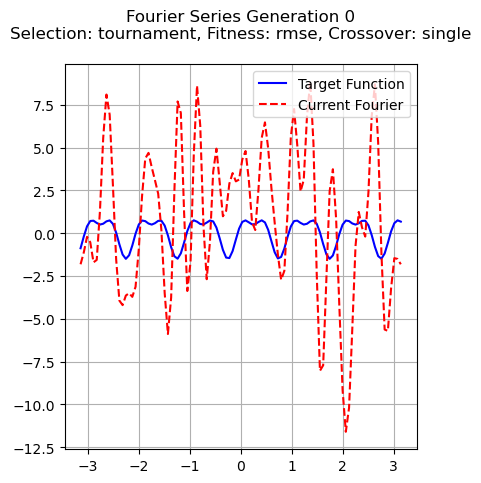

Generation 50: Best Fitness = 0.6237, RMSE = 1.6032


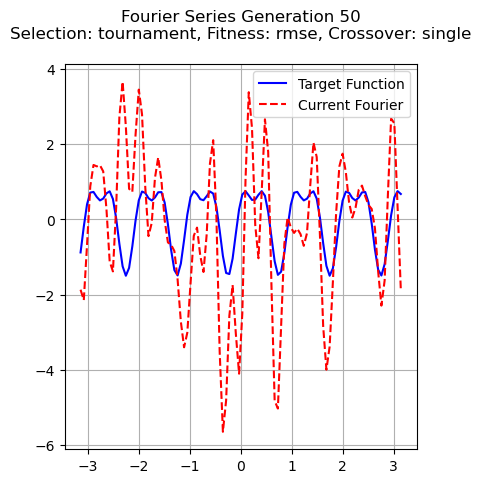

Generation 100: Best Fitness = 1.7732, RMSE = 0.5640


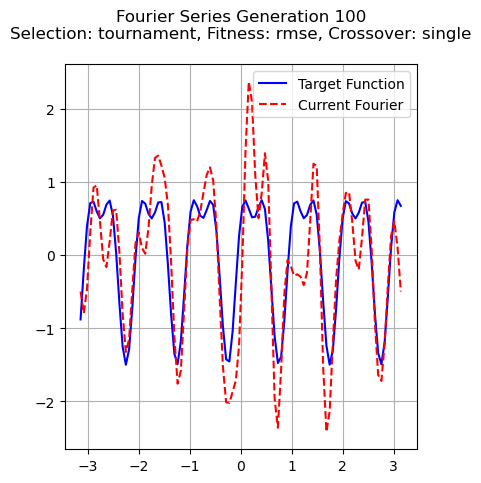

Generation 150: Best Fitness = 3.8877, RMSE = 0.2572


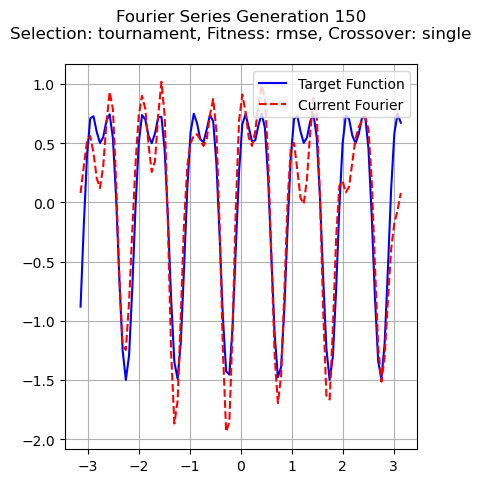

Generation 200: Best Fitness = 5.1626, RMSE = 0.1937


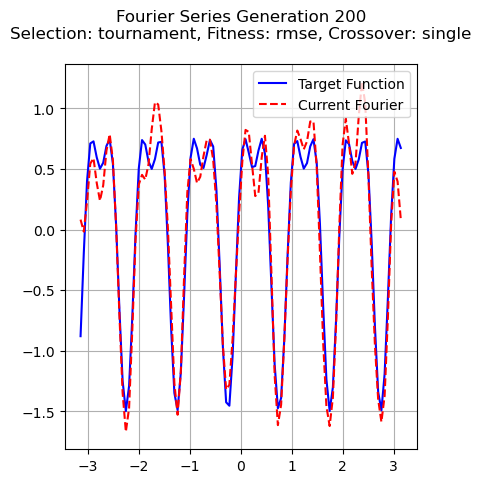

Generation 250: Best Fitness = 6.5222, RMSE = 0.1533


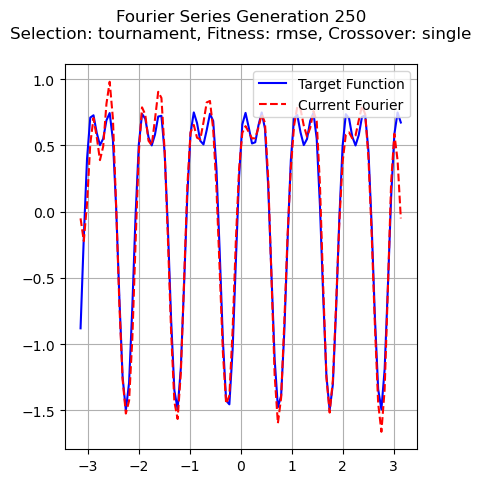

Generation 300: Best Fitness = 7.3980, RMSE = 0.1352


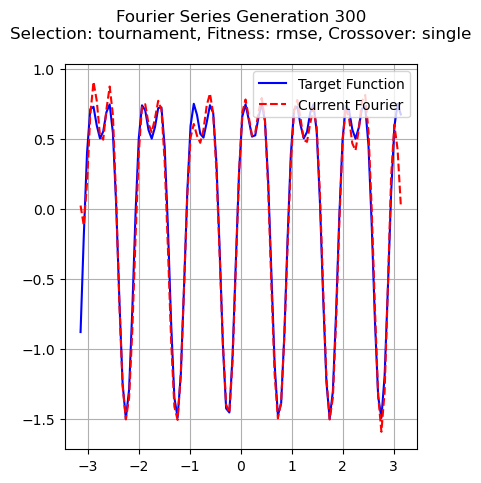

Generation 350: Best Fitness = 7.7542, RMSE = 0.1290


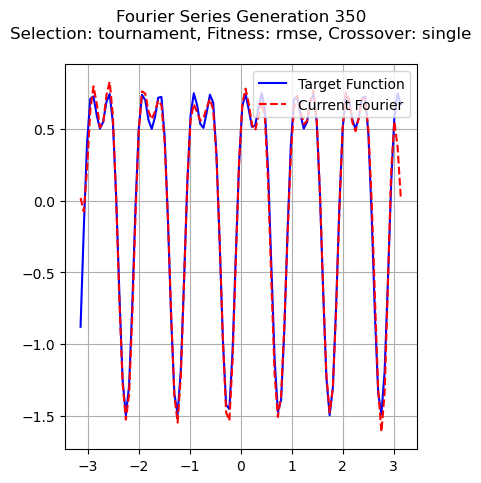

Generation 400: Best Fitness = 7.9385, RMSE = 0.1260


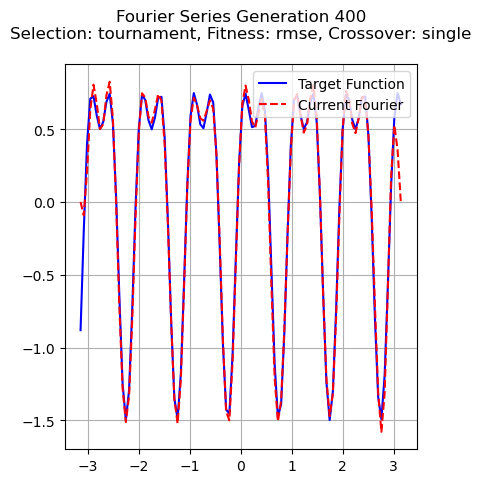


Final Best Fitness: 7.9385, Final RMSE: 0.1260


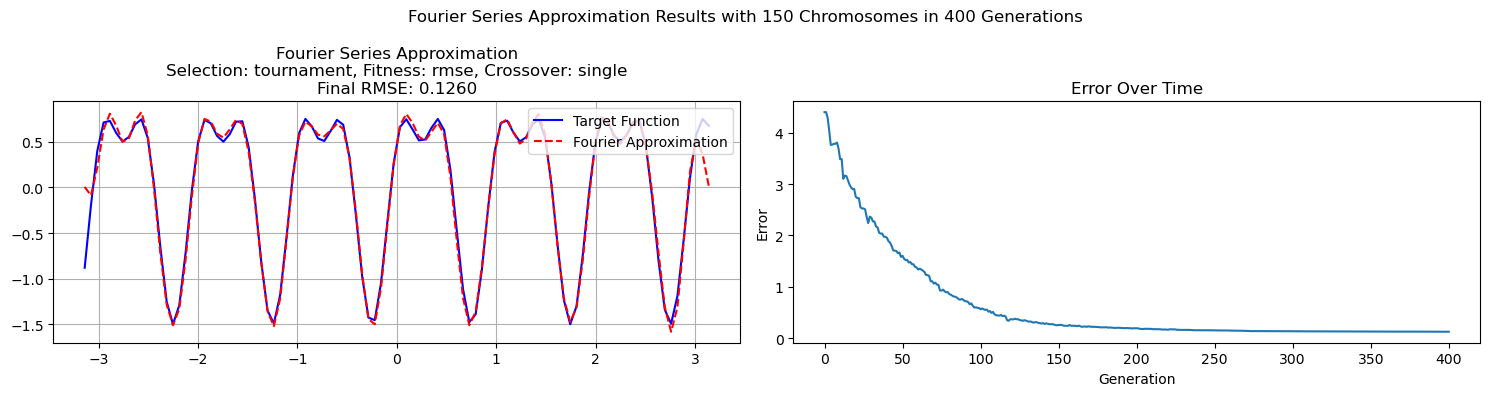


Best Fourier Coefficients:
a0: 0.0028
a1: -0.0216, b1: -0.0118
a2: 0.0164, b2: 0.0249
a3: -0.0183, b3: -0.0592
a4: 0.0287, b4: 0.0830
a5: -0.0135, b5: -0.1803
a6: 0.0203, b6: 0.8752
a7: -0.0136, b7: 0.3667
a8: 0.0408, b8: -0.1535
a9: -0.0495, b9: 0.1167
a10: 0.0628, b10: -0.0669
a11: -0.1133, b11: 0.0634
a12: 0.2760, b12: -0.0549
a13: 0.3474, b13: 0.0579
a14: -0.1002, b14: -0.0374
a15: 0.0706, b15: 0.0425
a16: -0.0431, b16: -0.0280
a17: 0.0408, b17: 0.0321
a18: -0.0240, b18: -0.0236
a19: 0.0199, b19: 0.0261
a20: -0.0259, b20: -0.0260


In [39]:
selection = "tournament"
fitness = "rmse"
crossover = "single"
print(f"\nRunning with Selection: {selection}, Fitness: {fitness}, Crossover: {crossover}")
GA = GeneticAlgorithm("sin_cos", crossover, selection, fitness)
best, best_fitnesses, best_rmses = GA.run_GA()
GA.visualize(best, best_fitnesses, best_rmses)


Running with Selection: tournament, Fitness: mae, Crossover: single
Generation 0: Best Fitness = 0.2849, MAE = 3.5105


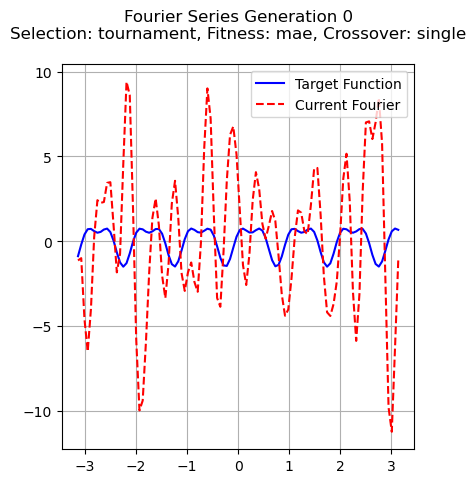

Generation 50: Best Fitness = 0.7238, MAE = 1.3816


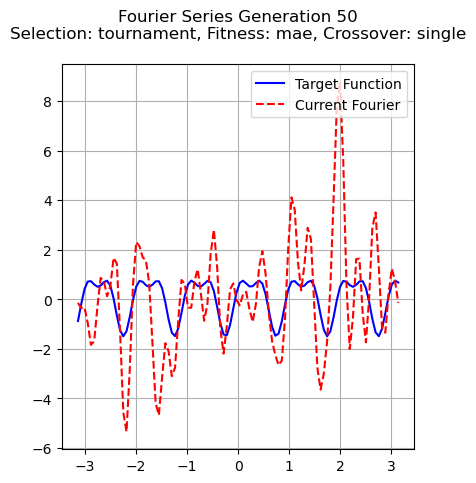

Generation 100: Best Fitness = 1.6104, MAE = 0.6210


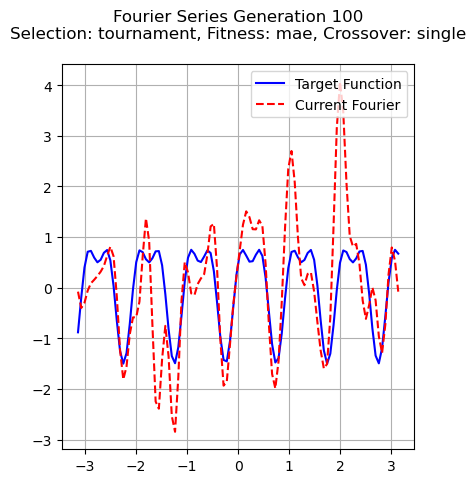

Generation 150: Best Fitness = 3.4034, MAE = 0.2938


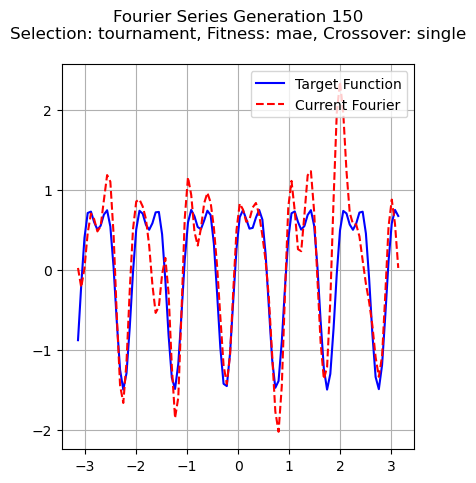

Generation 200: Best Fitness = 5.5954, MAE = 0.1787


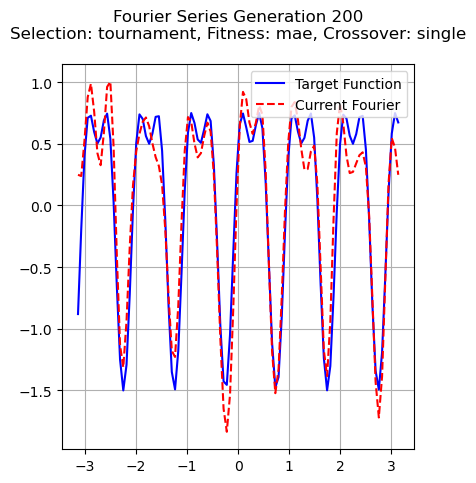

Generation 250: Best Fitness = 8.3916, MAE = 0.1192


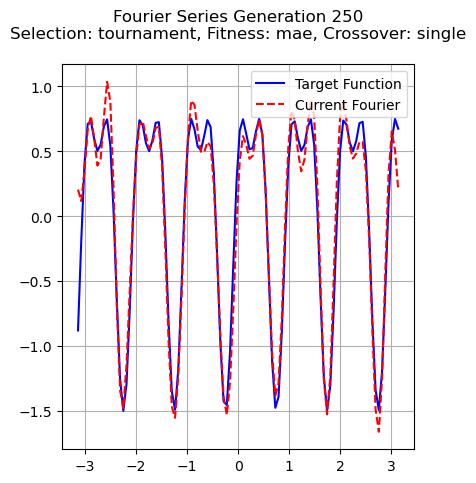

Generation 300: Best Fitness = 11.6039, MAE = 0.0862


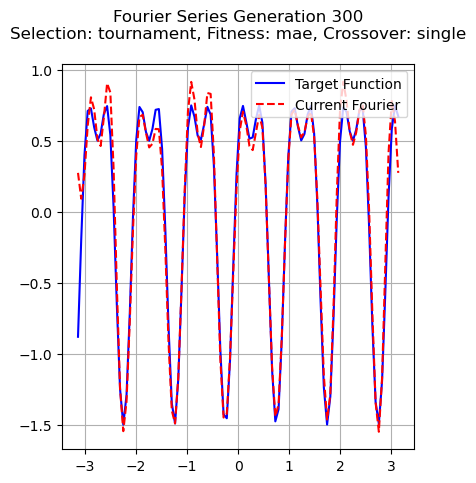

Generation 350: Best Fitness = 13.7871, MAE = 0.0725


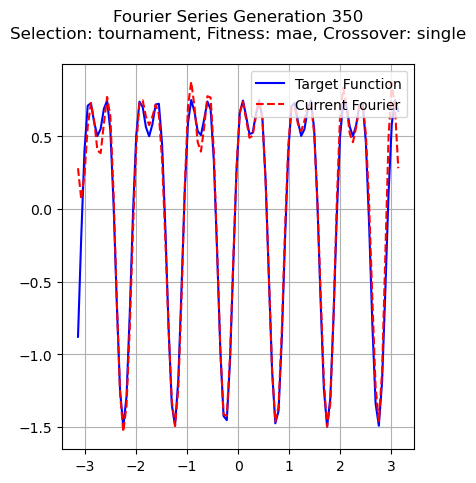

Generation 400: Best Fitness = 16.1495, MAE = 0.0619


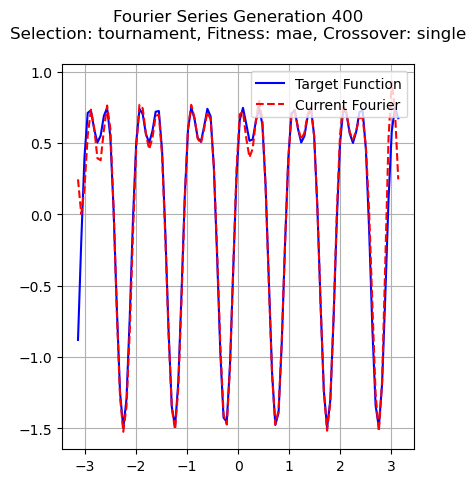


Final Best Fitness: 16.1495, Final MAE: 0.0619


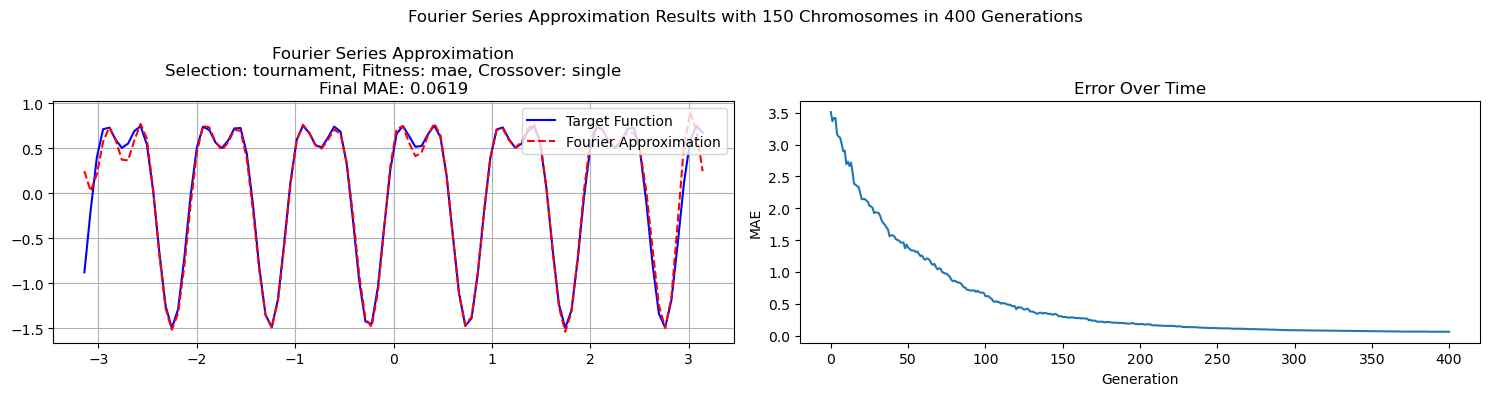


Best Fourier Coefficients:
a0: 0.0356
a1: -0.0477, b1: 0.0123
a2: 0.0492, b2: 0.0022
a3: -0.0478, b3: -0.0319
a4: 0.0414, b4: 0.0553
a5: -0.0467, b5: -0.1532
a6: 0.0421, b6: 0.8247
a7: -0.0434, b7: 0.3836
a8: 0.0467, b8: -0.1910
a9: -0.0619, b9: 0.1123
a10: 0.0835, b10: -0.0745
a11: -0.1166, b11: 0.0649
a12: 0.2841, b12: -0.0641
a13: 0.3677, b13: 0.0647
a14: -0.0957, b14: -0.0478
a15: 0.0759, b15: 0.0528
a16: -0.0367, b16: -0.0432
a17: 0.0483, b17: 0.0426
a18: -0.0308, b18: -0.0293
a19: 0.0274, b19: 0.0265
a20: -0.0015, b20: -0.0101


In [40]:
selection = "tournament"
fitness = "mae"
crossover = "single"
print(f"\nRunning with Selection: {selection}, Fitness: {fitness}, Crossover: {crossover}")
GA = GeneticAlgorithm("sin_cos", crossover, selection, fitness)
best, best_fitnesses, best_rmses = GA.run_GA()
GA.visualize(best, best_fitnesses, best_rmses)


Running with Selection: tournament, Fitness: r2, Crossover: single
Generation 0: Best Fitness = -29.8660, R² = -29.8660


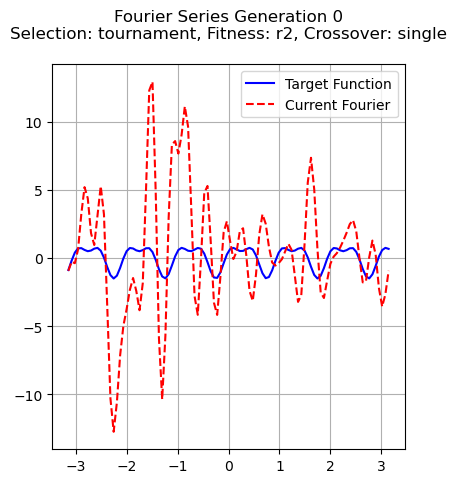

Generation 50: Best Fitness = -2.3727, R² = -2.3727


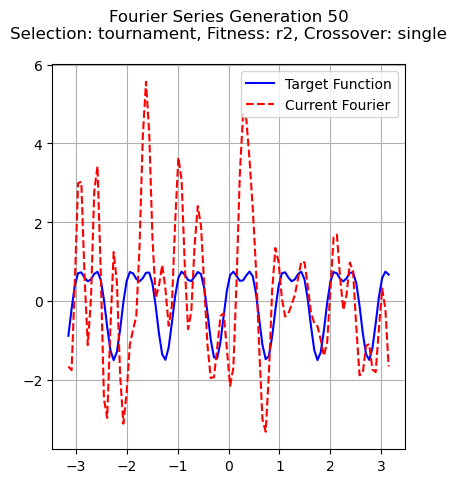

Generation 100: Best Fitness = 0.6621, R² = 0.6621


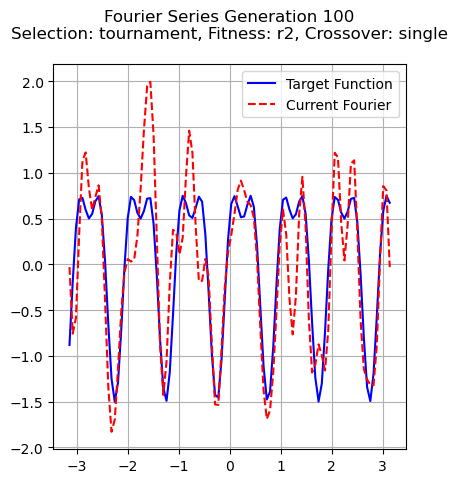

Generation 150: Best Fitness = 0.9221, R² = 0.9221


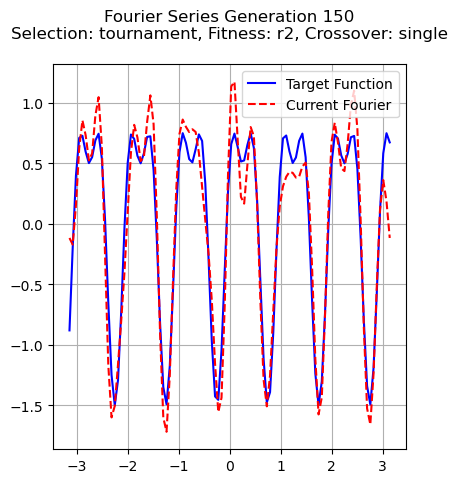

Generation 200: Best Fitness = 0.9468, R² = 0.9468


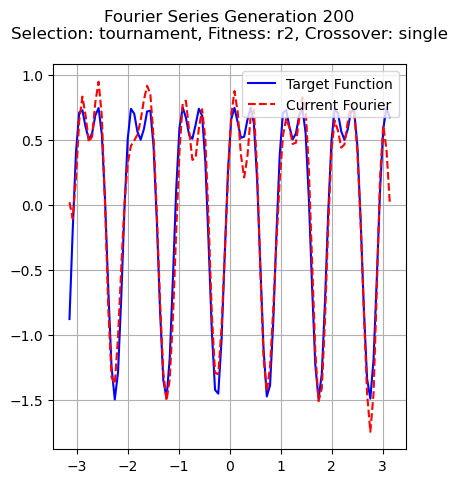

Generation 250: Best Fitness = 0.9609, R² = 0.9609


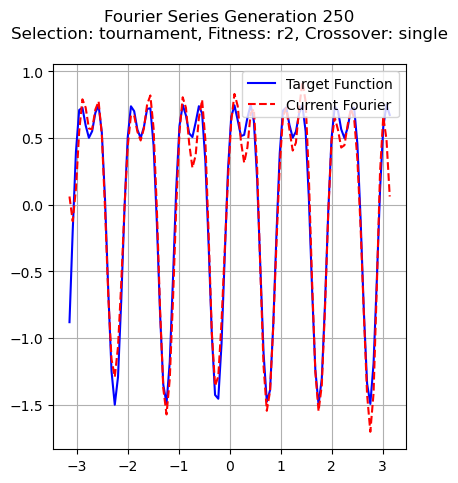

Generation 300: Best Fitness = 0.9688, R² = 0.9688


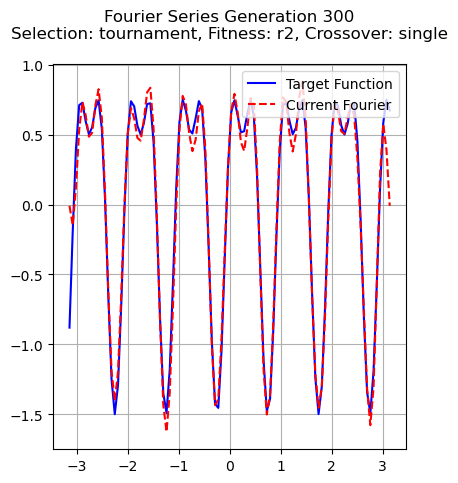

Generation 350: Best Fitness = 0.9713, R² = 0.9713


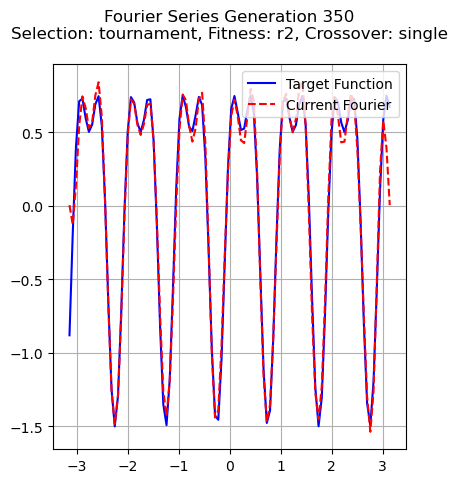

Generation 400: Best Fitness = 0.9735, R² = 0.9735


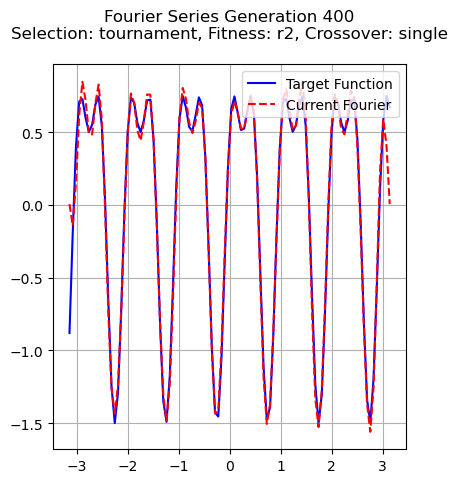


Final Best Fitness: 0.9735, Final R²: 0.9735


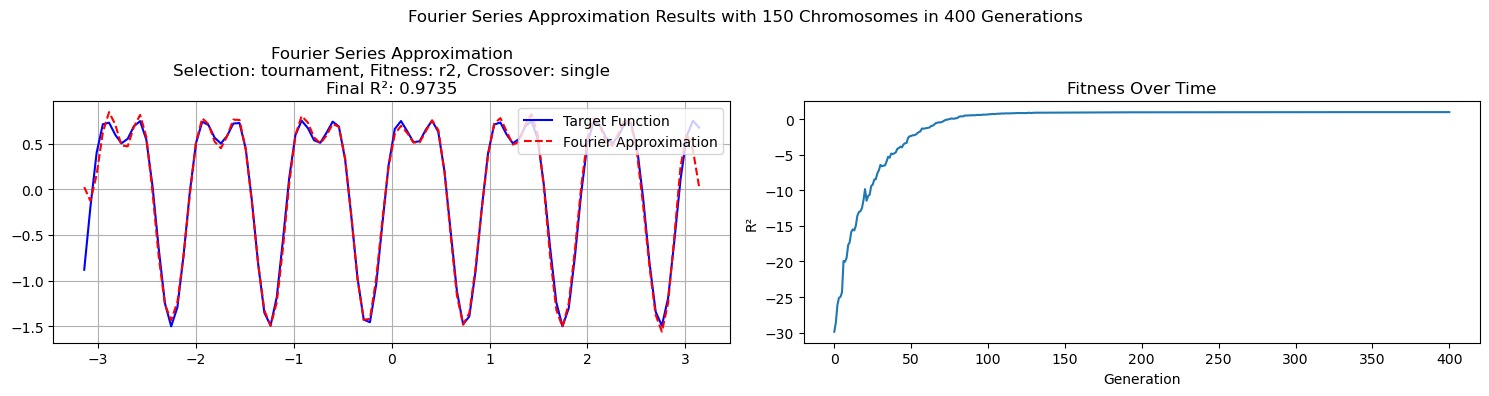


Best Fourier Coefficients:
a0: 0.0173
a1: -0.0181, b1: -0.0098
a2: 0.0152, b2: 0.0303
a3: -0.0187, b3: -0.0582
a4: 0.0238, b4: 0.0837
a5: -0.0326, b5: -0.1800
a6: 0.0357, b6: 0.8513
a7: -0.0332, b7: 0.3708
a8: 0.0346, b8: -0.1666
a9: -0.0382, b9: 0.0965
a10: 0.0566, b10: -0.0944
a11: -0.1132, b11: 0.0754
a12: 0.2638, b12: -0.0687
a13: 0.3706, b13: 0.0463
a14: -0.1050, b14: -0.0337
a15: 0.0609, b15: 0.0277
a16: -0.0417, b16: -0.0475
a17: 0.0341, b17: 0.0295
a18: -0.0372, b18: -0.0261
a19: 0.0068, b19: 0.0418
a20: -0.0129, b20: -0.0329


In [41]:
selection = "tournament"
fitness = "r2"
crossover = "single"
print(f"\nRunning with Selection: {selection}, Fitness: {fitness}, Crossover: {crossover}")
GA = GeneticAlgorithm("sin_cos", crossover, selection, fitness)
best, best_fitnesses, best_rmses = GA.run_GA()
GA.visualize(best, best_fitnesses, best_rmses)


Running with Selection: tournament, Fitness: rmse, Crossover: uniform
Generation 0: Best Fitness = 0.2162, RMSE = 4.6251


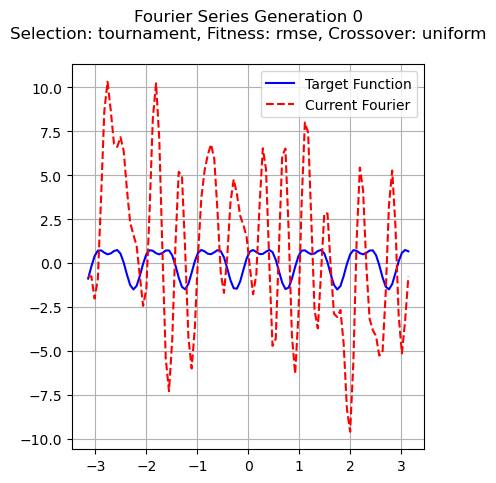

Generation 50: Best Fitness = 1.6127, RMSE = 0.6201


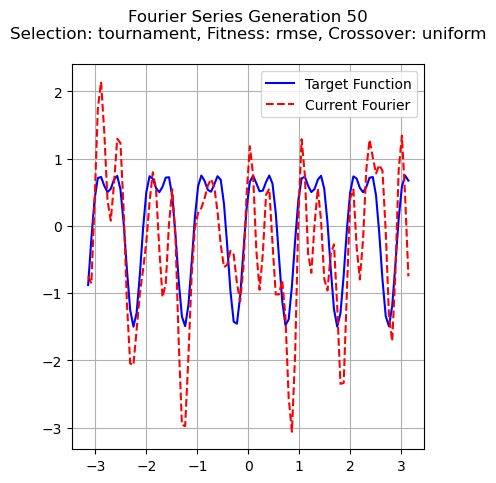

Generation 100: Best Fitness = 3.4554, RMSE = 0.2894


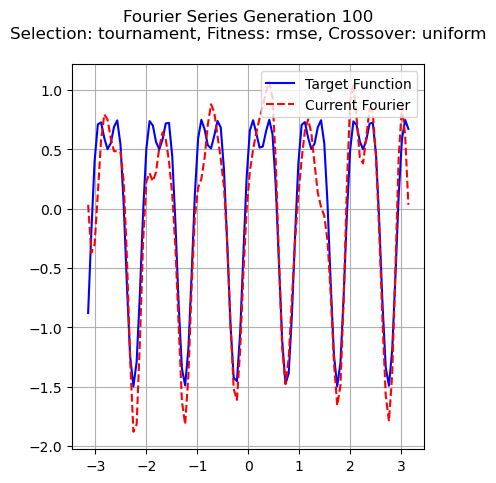

Generation 150: Best Fitness = 4.8516, RMSE = 0.2061


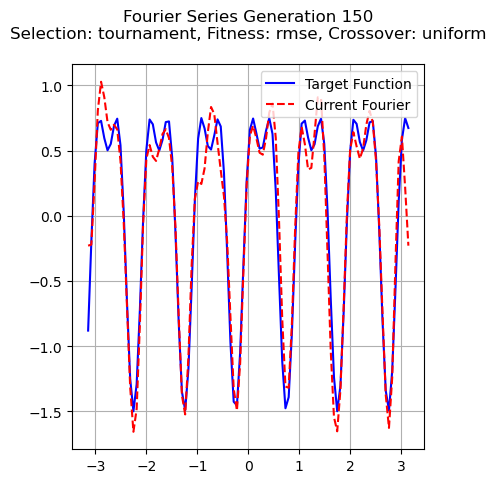

Generation 200: Best Fitness = 6.2497, RMSE = 0.1600


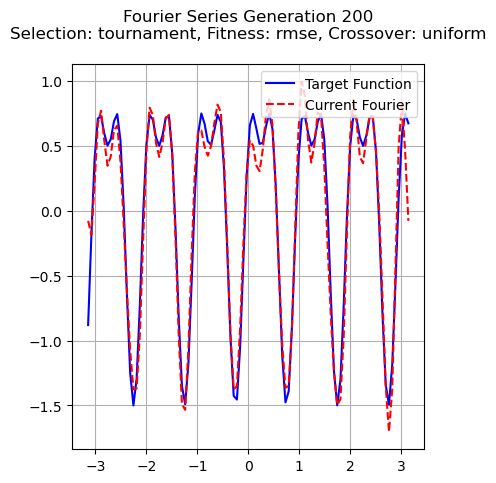

Generation 250: Best Fitness = 7.0763, RMSE = 0.1413


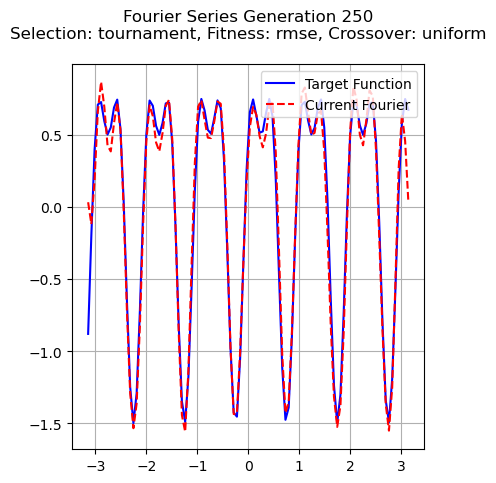

Generation 300: Best Fitness = 7.5267, RMSE = 0.1329


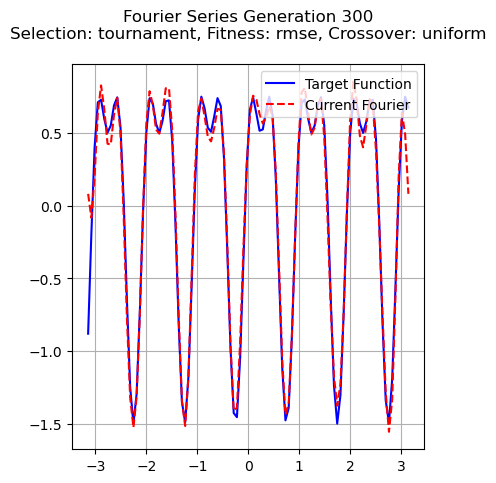

Generation 350: Best Fitness = 7.8841, RMSE = 0.1268


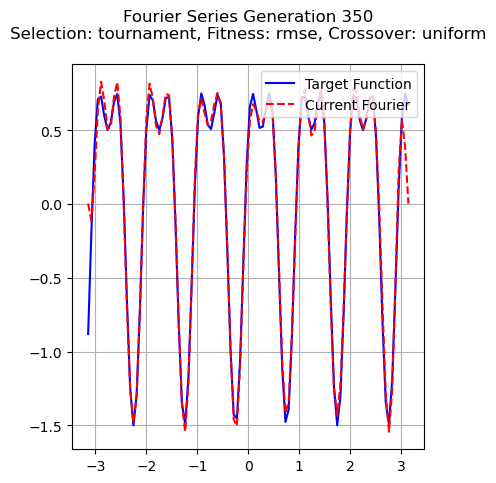

Generation 400: Best Fitness = 7.9559, RMSE = 0.1257


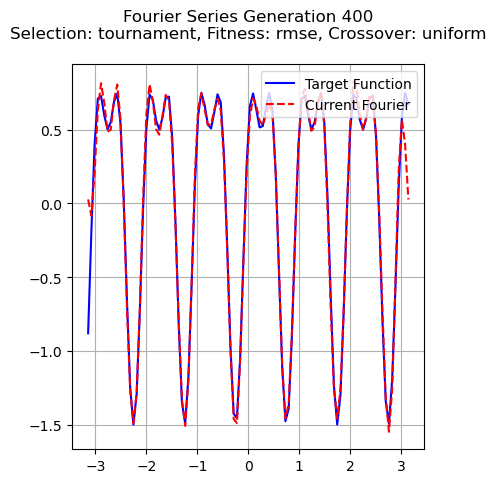


Final Best Fitness: 7.9559, Final RMSE: 0.1257


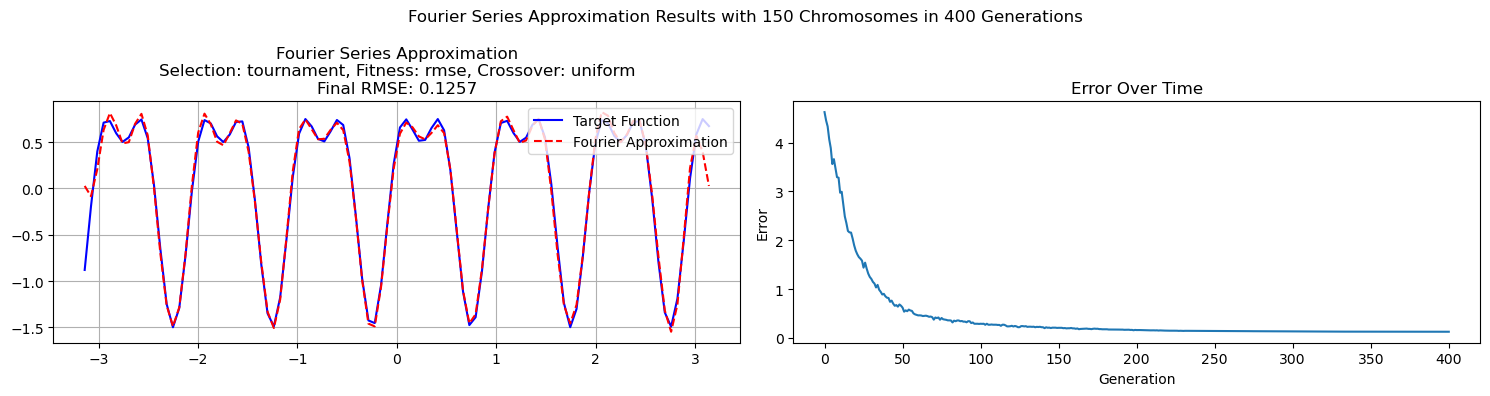


Best Fourier Coefficients:
a0: 0.0224
a1: -0.0317, b1: -0.0101
a2: 0.0120, b2: 0.0274
a3: -0.0204, b3: -0.0435
a4: 0.0070, b4: 0.0900
a5: -0.0287, b5: -0.1746
a6: 0.0417, b6: 0.8564
a7: -0.0248, b7: 0.3615
a8: 0.0258, b8: -0.1575
a9: -0.0407, b9: 0.1061
a10: 0.0661, b10: -0.0802
a11: -0.1109, b11: 0.0728
a12: 0.2796, b12: -0.0489
a13: 0.3503, b13: 0.0460
a14: -0.1182, b14: -0.0436
a15: 0.0609, b15: 0.0440
a16: -0.0534, b16: -0.0367
a17: 0.0308, b17: 0.0255
a18: -0.0195, b18: -0.0201
a19: 0.0202, b19: 0.0212
a20: -0.0204, b20: -0.0366


In [42]:
selection = "tournament"
fitness = "rmse"
crossover = "uniform"
print(f"\nRunning with Selection: {selection}, Fitness: {fitness}, Crossover: {crossover}")
GA = GeneticAlgorithm("sin_cos", crossover, selection, fitness)
best, best_fitnesses, best_rmses = GA.run_GA()
GA.visualize(best, best_fitnesses, best_rmses)


Running with Selection: tournament, Fitness: rmse, Crossover: n_point
Generation 0: Best Fitness = 0.2135, RMSE = 4.6828


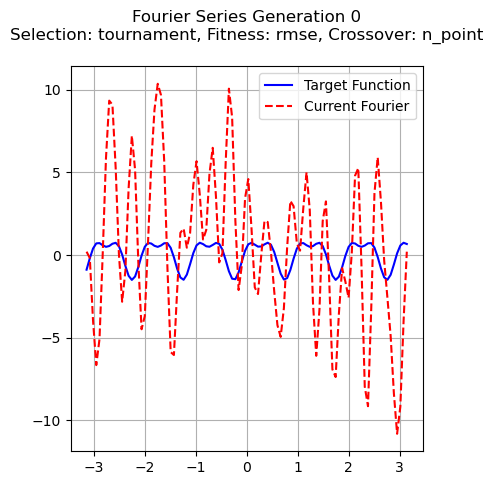

Generation 50: Best Fitness = 0.6768, RMSE = 1.4774


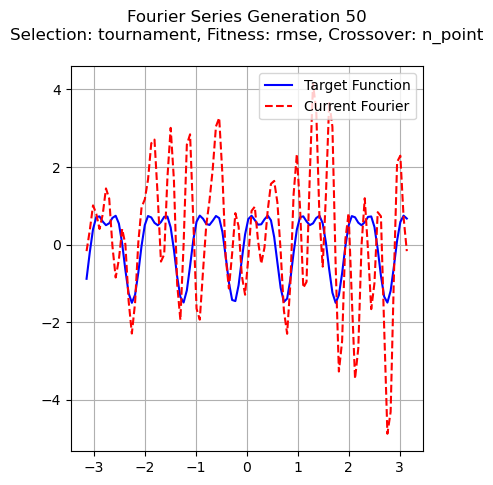

Generation 100: Best Fitness = 2.0604, RMSE = 0.4853


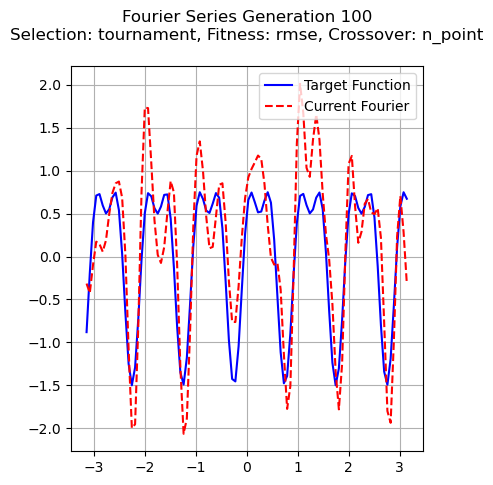

Generation 150: Best Fitness = 4.0683, RMSE = 0.2458


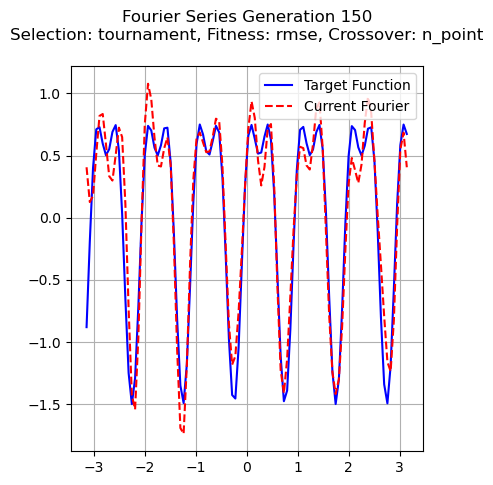

Generation 200: Best Fitness = 5.3726, RMSE = 0.1861


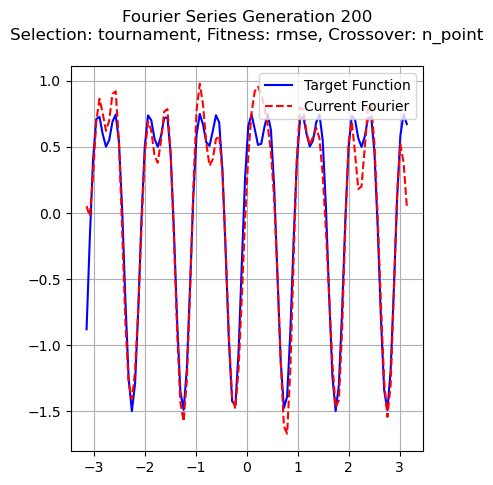

Generation 250: Best Fitness = 6.4247, RMSE = 0.1556


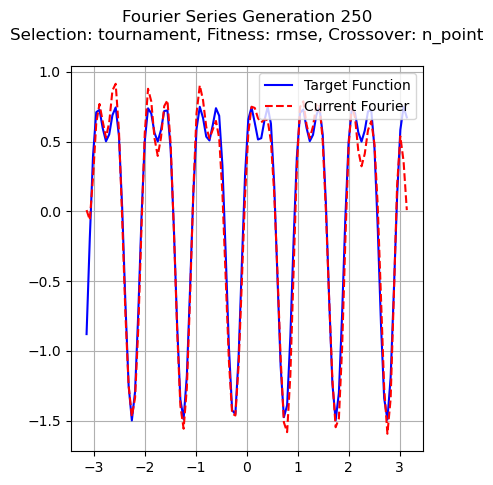

Generation 300: Best Fitness = 7.3560, RMSE = 0.1359


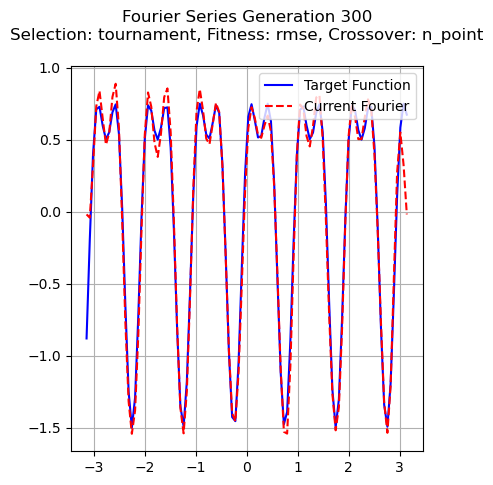

Generation 350: Best Fitness = 7.7539, RMSE = 0.1290


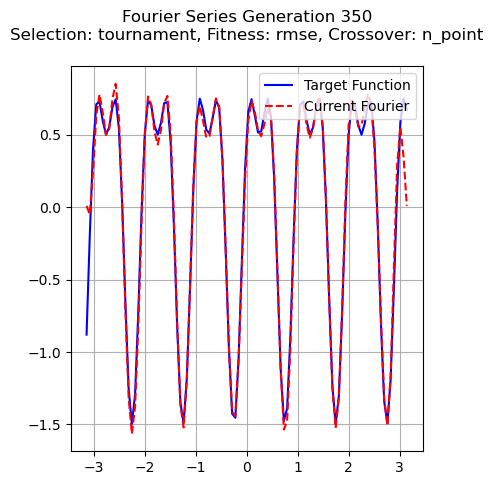

Generation 400: Best Fitness = 7.9250, RMSE = 0.1262


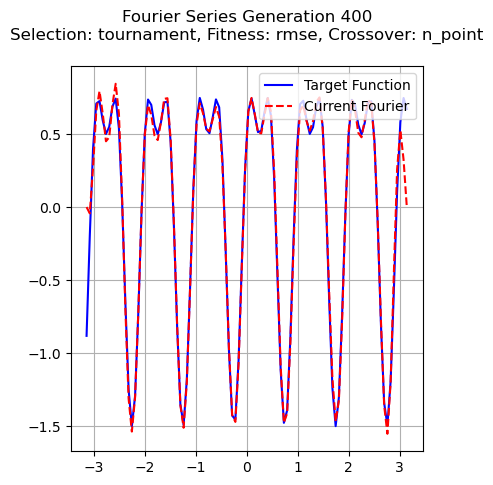


Final Best Fitness: 7.9250, Final RMSE: 0.1262


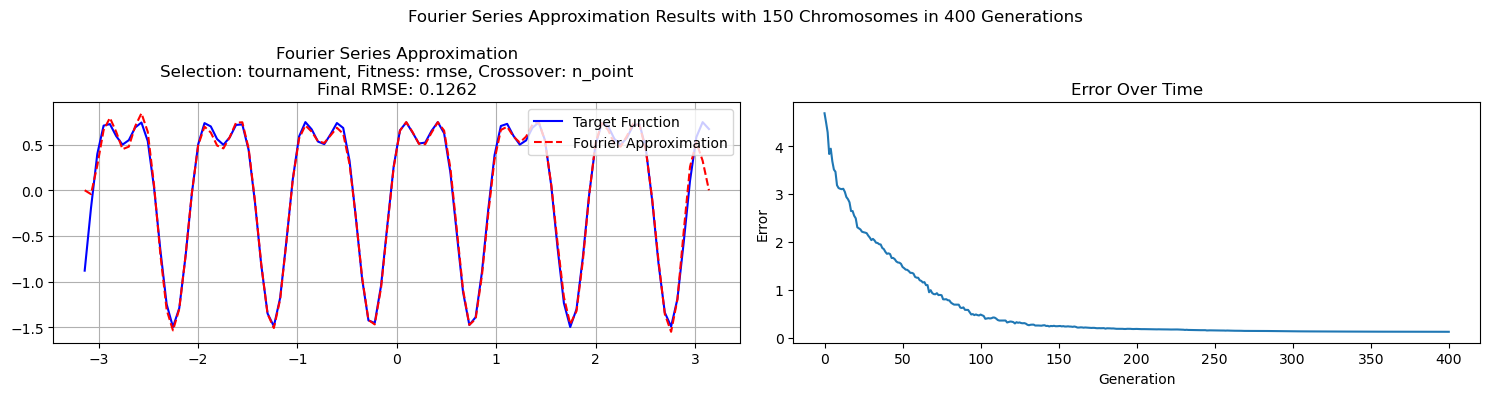


Best Fourier Coefficients:
a0: 0.0124
a1: -0.0252, b1: -0.0061
a2: 0.0225, b2: 0.0313
a3: -0.0246, b3: -0.0505
a4: 0.0302, b4: 0.0933
a5: -0.0185, b5: -0.1650
a6: 0.0118, b6: 0.8500
a7: -0.0353, b7: 0.3604
a8: 0.0405, b8: -0.1662
a9: -0.0423, b9: 0.1002
a10: 0.0656, b10: -0.0859
a11: -0.1030, b11: 0.0690
a12: 0.2780, b12: -0.0407
a13: 0.3580, b13: 0.0385
a14: -0.1222, b14: -0.0275
a15: 0.0785, b15: 0.0365
a16: -0.0482, b16: -0.0219
a17: 0.0326, b17: 0.0301
a18: -0.0234, b18: -0.0299
a19: 0.0249, b19: 0.0144
a20: -0.0140, b20: -0.0103


In [43]:
selection = "tournament"
fitness = "rmse"
crossover = "n_point"
print(f"\nRunning with Selection: {selection}, Fitness: {fitness}, Crossover: {crossover}")
GA = GeneticAlgorithm("sin_cos", crossover, selection, fitness)
best, best_fitnesses, best_rmses = GA.run_GA()
GA.visualize(best, best_fitnesses, best_rmses)


Running with Selection: roulette, Fitness: rmse, Crossover: uniform
Generation 0: Best Fitness = 0.2260, RMSE = 4.4246


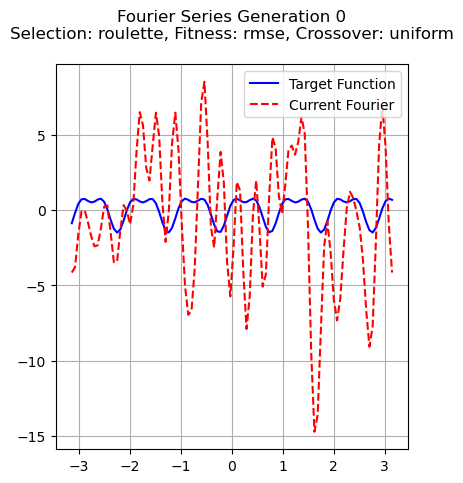

Generation 50: Best Fitness = 1.0806, RMSE = 0.9254


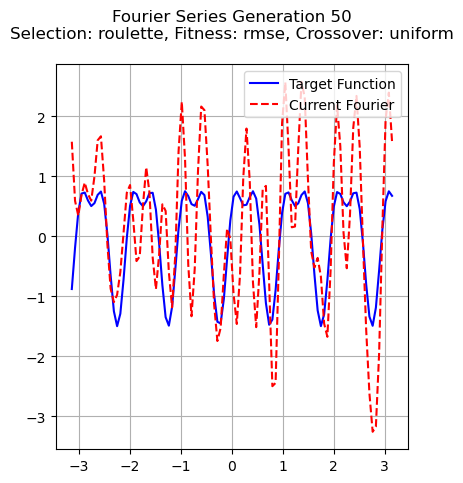

Generation 100: Best Fitness = 3.2424, RMSE = 0.3084


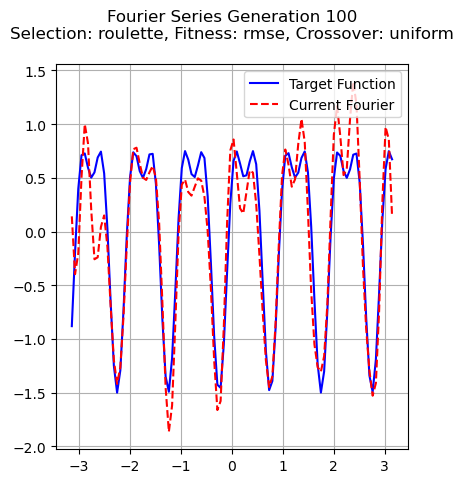

Generation 150: Best Fitness = 4.9281, RMSE = 0.2029


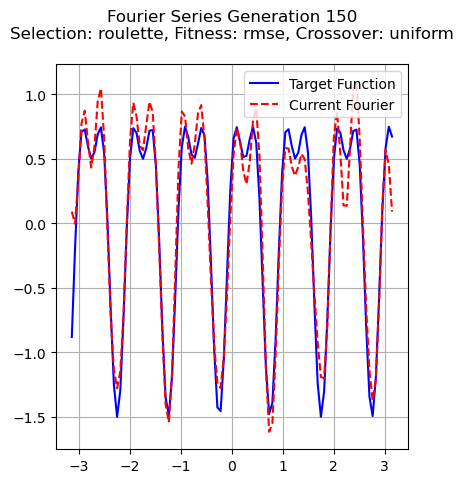

Generation 200: Best Fitness = 5.5964, RMSE = 0.1787


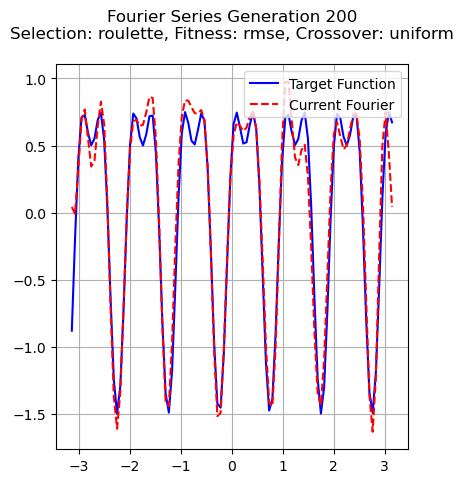

Generation 250: Best Fitness = 6.7056, RMSE = 0.1491


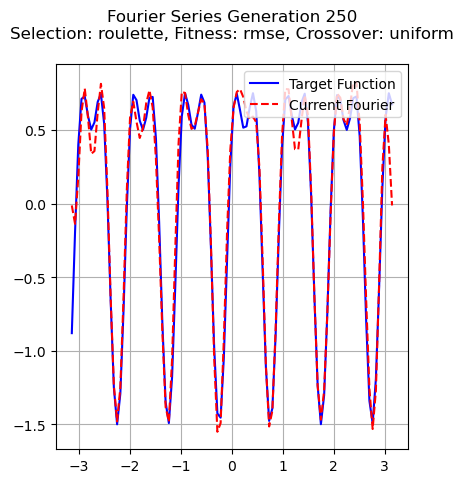

Generation 300: Best Fitness = 7.0812, RMSE = 0.1412


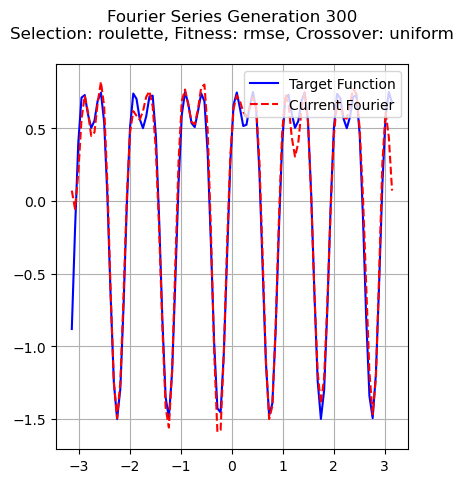

Generation 350: Best Fitness = 7.2691, RMSE = 0.1376


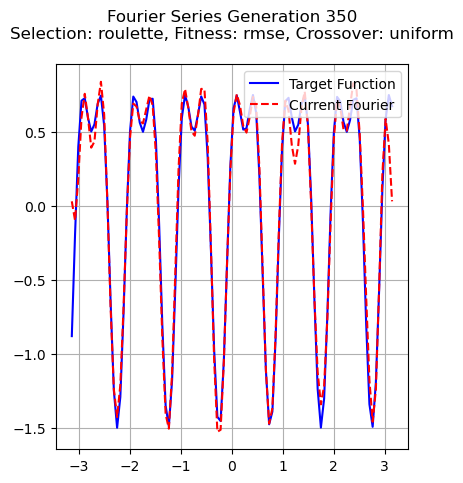

Generation 400: Best Fitness = 7.3803, RMSE = 0.1355


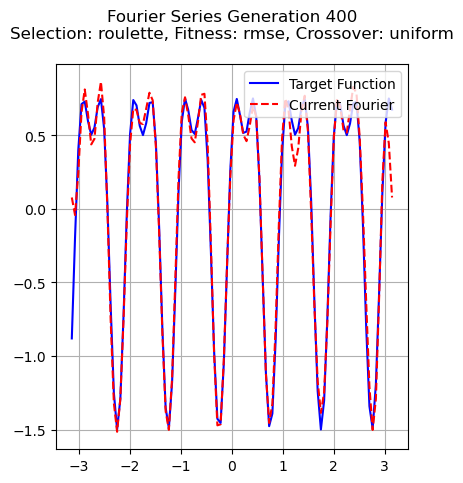


Final Best Fitness: 7.3803, Final RMSE: 0.1355


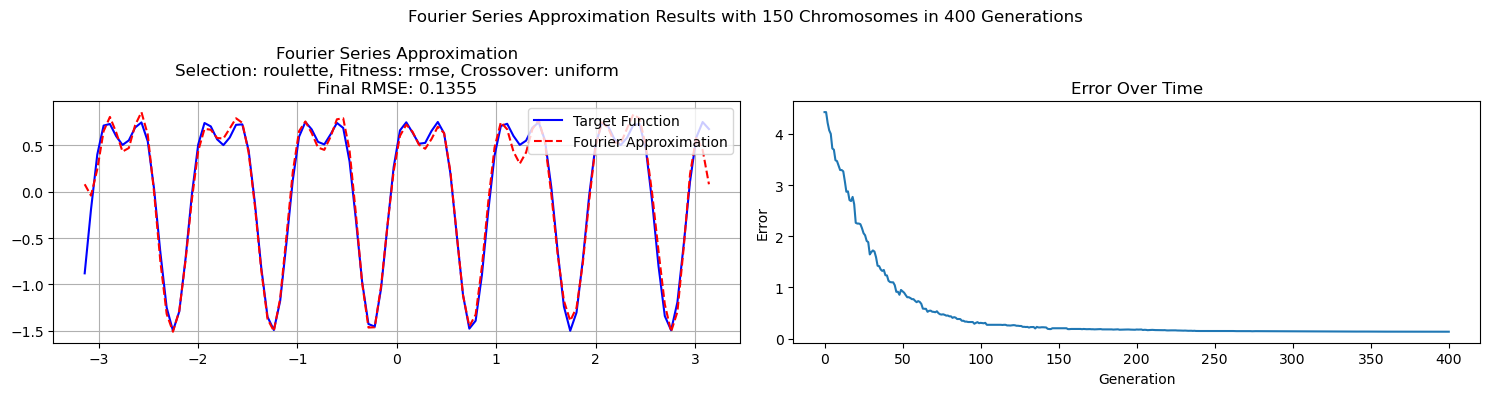


Best Fourier Coefficients:
a0: 0.0273
a1: -0.0283, b1: -0.0137
a2: 0.0276, b2: 0.0070
a3: -0.0267, b3: -0.0344
a4: 0.0084, b4: 0.0851
a5: -0.0323, b5: -0.1902
a6: 0.0107, b6: 0.8407
a7: -0.0129, b7: 0.3437
a8: 0.0533, b8: -0.1498
a9: -0.0743, b9: 0.1202
a10: 0.0607, b10: -0.0596
a11: -0.1011, b11: 0.0707
a12: 0.3016, b12: -0.0634
a13: 0.3571, b13: 0.0308
a14: -0.0912, b14: -0.0313
a15: 0.0578, b15: 0.0414
a16: -0.0680, b16: -0.0421
a17: 0.0259, b17: 0.0300
a18: -0.0236, b18: -0.0415
a19: 0.0166, b19: 0.0384
a20: -0.0325, b20: -0.0219


In [44]:
selection = "roulette"
fitness = "rmse"
crossover = "uniform"
print(f"\nRunning with Selection: {selection}, Fitness: {fitness}, Crossover: {crossover}")
GA = GeneticAlgorithm("sin_cos", crossover, selection, fitness)
best, best_fitnesses, best_rmses = GA.run_GA()
GA.visualize(best, best_fitnesses, best_rmses)


Running with Selection: rank, Fitness: rmse, Crossover: uniform
Generation 0: Best Fitness = 0.2120, RMSE = 4.7170


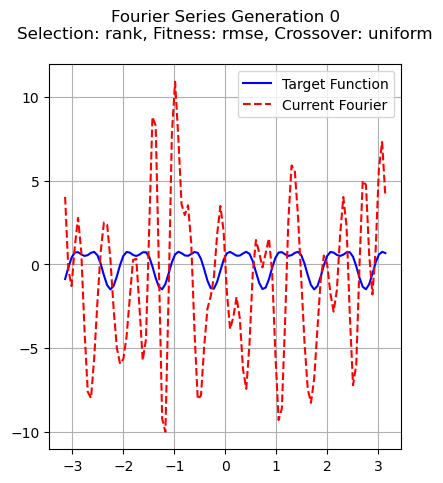

Generation 50: Best Fitness = 0.3430, RMSE = 2.9153


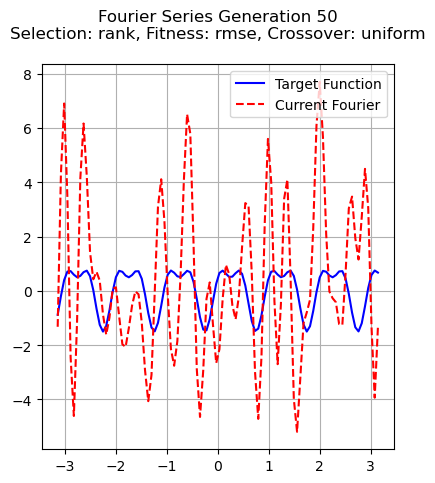

Generation 100: Best Fitness = 0.4711, RMSE = 2.1226


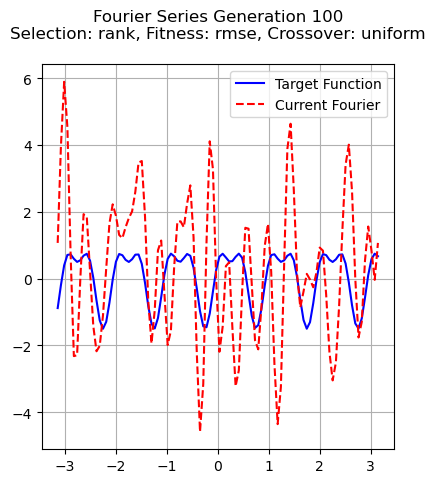

Generation 150: Best Fitness = 0.5926, RMSE = 1.6874


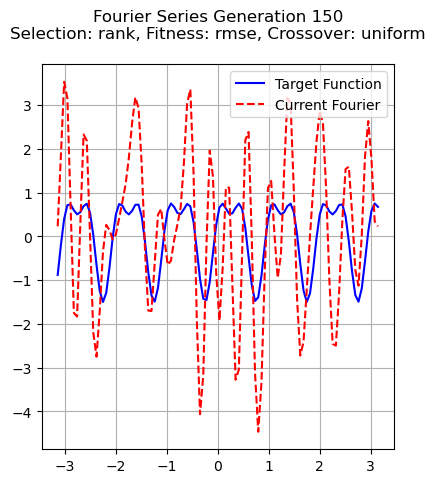

Generation 200: Best Fitness = 0.7892, RMSE = 1.2671


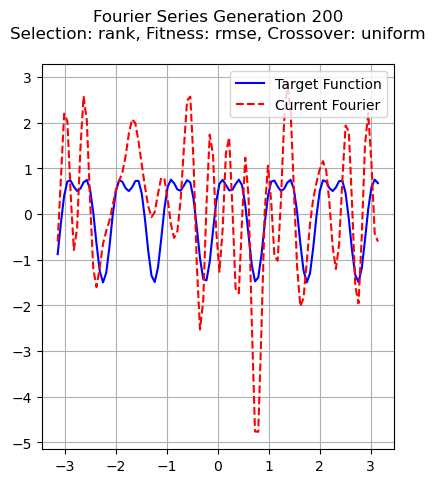

Generation 250: Best Fitness = 1.0588, RMSE = 0.9445


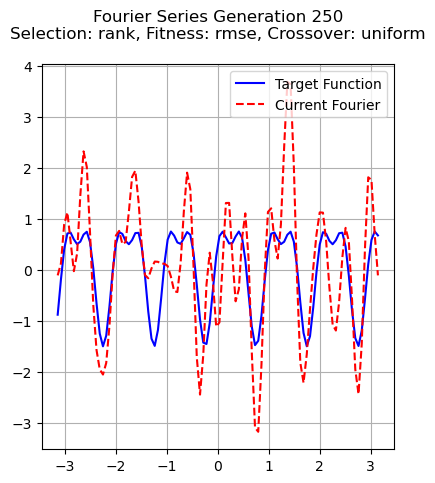

Generation 300: Best Fitness = 1.3896, RMSE = 0.7196


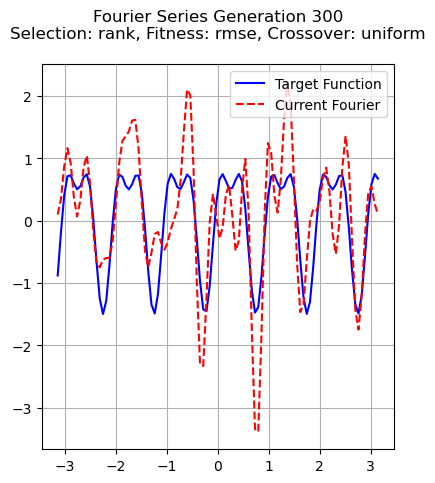

Generation 350: Best Fitness = 1.9192, RMSE = 0.5210


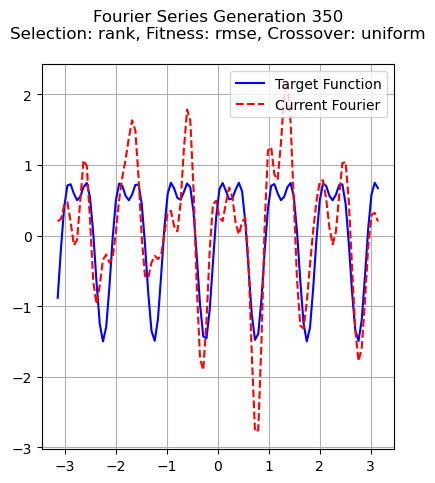

Generation 400: Best Fitness = 2.4794, RMSE = 0.4033


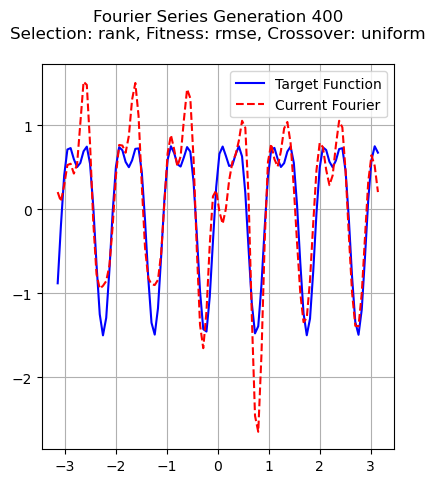


Final Best Fitness: 2.4794, Final RMSE: 0.4033


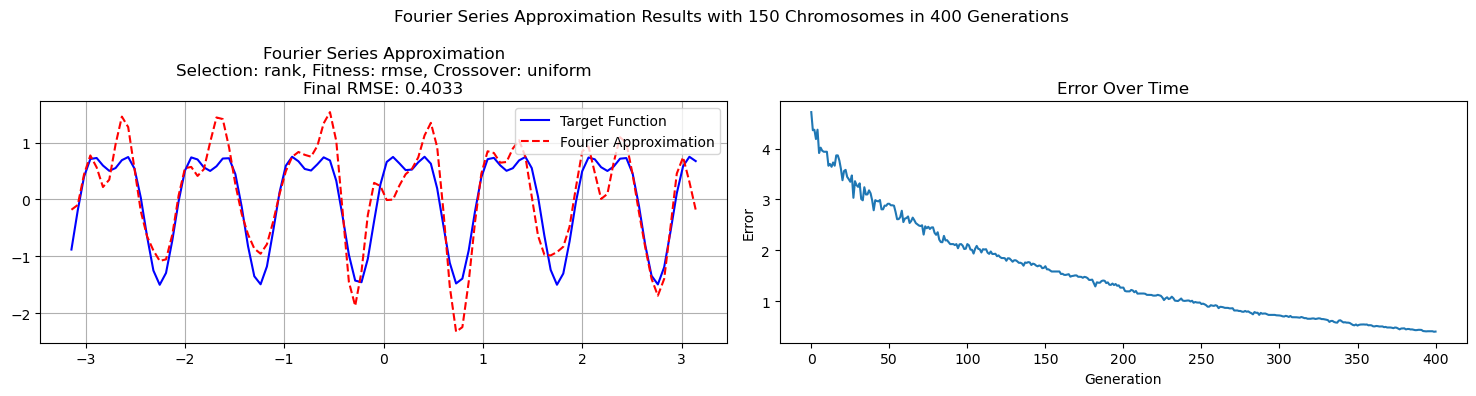


Best Fourier Coefficients:
a0: 0.1776
a1: -0.0124, b1: -0.1384
a2: -0.0317, b2: -0.0275
a3: -0.0028, b3: -0.1090
a4: 0.0199, b4: 0.1058
a5: -0.0535, b5: -0.1676
a6: -0.0705, b6: 0.8513
a7: -0.1032, b7: 0.4580
a8: -0.0738, b8: -0.1652
a9: -0.1382, b9: -0.0229
a10: 0.1847, b10: -0.2154
a11: 0.0163, b11: 0.0630
a12: 0.3279, b12: -0.2450
a13: 0.3426, b13: -0.0601
a14: -0.0529, b14: 0.0315
a15: 0.1087, b15: -0.0357
a16: -0.1498, b16: -0.0486
a17: -0.0940, b17: -0.1100
a18: -0.1256, b18: -0.0762
a19: 0.0770, b19: 0.0380
a20: -0.1573, b20: -0.0744


In [45]:
selection = "rank"
fitness = "rmse"
crossover = "uniform"
print(f"\nRunning with Selection: {selection}, Fitness: {fitness}, Crossover: {crossover}")
GA = GeneticAlgorithm("sin_cos", crossover, selection, fitness)
best, best_fitnesses, best_rmses = GA.run_GA()
GA.visualize(best, best_fitnesses, best_rmses)

From the result above it is obvious that the roulette selection doesnt work very well because it should calculate the fitness of each choromose each time although my individuals are sorted by they fitnesses but this selection should call the fitness calculator funtion each time.Another thing that I should mentioned is that the roulette selection depends on the probability so It gives a very high probability if the fitness is very good so the variety of our population may decrease so as the result we might loose good solution.
For all the reasons above I remove the roulette selection in my parameters to find the best combination.

In [ ]:
from sklearn.model_selection import ParameterGrid

def find_best_combination(params, ga_class, function_name="sin_cos"):
    best_score = -float('inf')
    best_params = None

    print("Finding Best Combination...")
    for p in ParameterGrid(params):
        print(f"\nTrying: {p}")
        ga = ga_class(function_name=function_name, **p)
        _, best_fitnesses, best_metrics = ga.run_GA()
        final_metric = best_metrics[-1]
        score = 1 / final_metric if p['fitness_type'] in ["rmse", "mae"] else final_metric
        
        if score > best_score:
            best_score = score
            best_params = p

    print(f"\nBest Combination: {best_params}")
    print(f"Best Score: {best_score:.4f}")

    return best_params, best_score



params = {
        'selection_type': ["tournament", "rank"],
        'crossover_type': ["uniform", "single", "n_point"],
        'fitness_type': ["rmse", "mae", "r2"]
    }
best_params, best_score = find_best_combination(params, GeneticAlgorithm, function_name="sin_cos")

Finding Best Combination...

Trying: {'crossover_type': 'uniform', 'fitness_type': 'rmse', 'selection_type': 'tournament'}

Final Best Fitness: 8.0114, Final RMSE: 0.1248

Trying: {'crossover_type': 'uniform', 'fitness_type': 'rmse', 'selection_type': 'rank'}

Final Best Fitness: 2.1708, Final RMSE: 0.4607

Trying: {'crossover_type': 'uniform', 'fitness_type': 'mae', 'selection_type': 'tournament'}

Final Best Fitness: 22.5127, Final MAE: 0.0444

Trying: {'crossover_type': 'uniform', 'fitness_type': 'mae', 'selection_type': 'rank'}

Final Best Fitness: 1.4035, Final MAE: 0.7125

Trying: {'crossover_type': 'uniform', 'fitness_type': 'r2', 'selection_type': 'tournament'}

Final Best Fitness: 0.9750, Final R²: 0.9750

Trying: {'crossover_type': 'uniform', 'fitness_type': 'r2', 'selection_type': 'rank'}

Final Best Fitness: 0.8727, Final R²: 0.8727

Trying: {'crossover_type': 'single', 'fitness_type': 'rmse', 'selection_type': 'tournament'}

Final Best Fitness: 7.9959, Final RMSE: 0.1251



So for the last result for the sin_cos :

Best Combination: {'crossover_type': 'uniform', 'fitness_type': 'mae', 'selection_type': 'tournament'}
Best Score: 22.5127

## <span style="color: #3498db;">Questions:</span>

## Q1:

In our genetic algorithm (GA) for Fourier series approximation, a **chromosome** represents the coefficients of a Fourier series that approximates a target function. Each chromosome is a vector of real numbers encoding the coefficients $(a_0, a_1, b_1, \ldots, a_n, b_n)$, where:

- $a_0$ is the constant term (divided by 2 in the Fourier series formula).
- $a_n$ and $b_n$ are the coefficients of the cosine and sine terms, respectively.

The Fourier series for an individual is expressed as:

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{N} \left( a_n \cos(nx) + b_n \sin(nx) \right)
$$

In our **ProblemValues** class, the `coe_value_limit` is set to the max abs of the fsamples, so each gene, which represents a coefficient of the Fourier series, is a number between (-ceo_value_limit, ceo_value_limit).

---

## Q2:
Here are two simple ideas to help our GA find a good Fourier series approximation (like for \( \sin(x) + \cos(x) \)) more quickly:

**Solution 1: Keep More of the Best Solutions (Increase Elitism)**  
In our GA, we already save the best 10% solutions in each generation using a method called elitism. This means we take the top 10% chromosomes with the best fitness—like the ones with the smallest error and copy them directly to the next generation. If we save more, like the top 20 instead of 10, the GA can focus on improving these really good solutions faster. For example, if a chromosome already gives a good approximation , keeping it ensures we don’t lose it while making new solutions. This can speed up convergence because we’re building on the best approximations more often, but we need to be careful not to save too many, or the GA might lose diversity and get stuck.

**Solution 2: Reduce Random Changes Faster (Lower Mutation Rate Sooner)**  
Our GA makes small random changes to the coefficients using Gaussian mutation to try new solutions. The amount of change is controlled by a mutation rate, which gets smaller over time with the formula 
$$ 
\text{mutation rate} * e^{{generation}/100} 
$$
This means in early generations, we make bigger changes to explore lots of different solutions, but in later generations, we make smaller changes to fine-tune the good solutions we’ve found. If we make the mutation rate decrease faster, like using 
$$
\text{mutation rate} * e^{{generation}/50} 
$$
  the GA will switch to fine-tuning sooner. For a function like 
$ \sin(x) + \cos(x) $, which doesn’t need big coefficient changes to get a good fit, this can help the GA converge faster by focusing on small adjustments to get the error down , instead of wasting time on big random changes that might make the solution worse.

---
## Q3:
I've combined the elitism method to all of my selestion strategies(I explained the elitism in the Q2, so I just explain my other to methods)

1. Roulette Wheel Selection

In this method, individuals are selected based on their fitness proportion. Imagine a roulette wheel where each individual has a slice proportional to its fitness. The wheel is spun, and the individual where the wheel stops is selected.

2. Tournament Selection

A subset of individuals is chosen randomly from the population, and the one with the highest fitness in this subset is selected. This process is repeated until the desired number of individuals is selected.

3. Rank-Based Selection

Individuals are ranked based on their fitness. The selection probability is then assigned based on this ranking rather than the absolute fitness values. This helps in maintaining diversity and avoiding premature convergence.

---

## Q4:

**Solution 1: Uniform Crossover to Add More Variety**  
In our GA, we have three crossover methods: `uniform`, `single`, and `n_point`. Premature convergence happens because the chromosomes become too similar, so we need more variety in the new solutions. The `uniform` crossover can help because it mixes the parents’ coefficients  in a more random way. This creates more diverse children compared to `single` or `n_point` crossover, which might only swap a few coefficients and make the children too similar to the parents. By using `uniform` crossover more often we can keep the population varied and reduce the chance of premature convergence, helping the GA find a better approximation with a lower error.

**Solution 2: Increasing the Mutation Rate in Early Generations**  
Another way that I use to fix premature convergence is to make more random changes to the chromosomes early on, so they don’t become too similar too quickly. In my code, I use Gaussian mutation to change the coefficientsby adding a small random value:

$$
\text{coefficient}' = \text{coefficient} + \mathcal{N}(0, \sigma)
$$

The amount of change is controlled by the mutation rate, which decreases over generations as:
$$
\text{mutation rate} * e^{{generation}/100} 
$$

that I explained it in the **Q2**. This helps the GA explore a wider range of Fourier series approximations early on, reducing the risk of getting stuck and allowing it to find a better solutionlater.

---
## Q5:
**R-squared (R²)** in our genetic algorithm is a fitness metric that measures how well the Fourier series approximation matches the target function . It ranges from 0 to 1, where:

- $ R^2 = 1 $: Perfect fit (the approximation matches the target exactly).
- $ R^2 = 0 $: The approximation is no better than just using the average of the target values.In simpler terms, my Fourier series is performing as poorly as a model that always predicts the average (mean) of the target values $y_real$, for every point.

In my `calculate_raw_fitness` method, R² is computed as:

$$
R^2 = 1 - \frac{\text{SSE}}{\text{SST}}
$$
However, in my GA, we sometimes see R² values less than 0. This happens because the SSE can be much larger than the SST if the Fourier series approximation is very poor, which is common in early generations when chromosomes are randomly initialized. This makes R² negative, indicating the approximation is worse than just using the average of the target.
Now I will explain my other error functions and then I will compare them to R2.

- **RMSE (Root Mean Squared Error)** measures the square root of the average squared differences between the predicted and actual values:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (y_{\text{predicted},i} - y_{\text{real},i})^2}
$$

Fitness is $$1 / (\text{RMSE} + \epsilon)$$, so a lower RMSE means a higher fitness.

- **MAE (Mean Absolute Error)** measures the average of the absolute differences between the predicted and actual values:

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^N |y_{\text{predicted},i} - y_{\text{real},i}|
$$

Fitness is $$1 / (\text{MAE} + \epsilon)$$, so a lower MAE means a higher fitness.

**Usefulness for This Problem**:
  - **R²**: R² is useful when we want to compare how well our Fourier series captures the overall pattern of different target functions (e.g.$ \sin(x) + \cos(x) $,$x^2 $, or a step function). It’s a good choice when we care about how much of the target’s variation (like oscillations or trends) is explained by the approximation, especially for functions with clear patterns. For example, for $\sin(x) + \cos(x)$, a high R² (e.g., 0.99) tells us the Fourier series is capturing the oscillatory behavior well. However, R² can be misleading for functions with very low variation (e.g., a nearly flat function), because even small errors can lead to a low or negative R². We should use R² as the fitness metric when our goal is to prioritize capturing the shape of the target function over minimizing raw error, especially in later generations when R² becomes positive.
  
  
  - **RMSE**: RMSE is useful for all types of target functions because it directly measures the error in the same units as the target (e.g., if $\sin(x) + \cos(x)$ ranges from -2 to 2, RMSE is in that range too). It’s especially helpful for functions where we care about the exact size of the errors, like when approximating a step function where large errors at the jumps are more noticeable. RMSE penalizes larger errors more heavily (due to squaring), so it’s good for ensuring the approximation is close to the target overall. We can use RMSE as the fitness metric when we want to focus on minimizing the actual error, especially for functions with sharp changes or when R² is negative in early generations.
  
  
  - **MAE**: MAE is useful when we want to treat all errors equally, without emphasizing larger errors as much as RMSE does. For example, for a target function like $ \sin(x) + \cos(x) $, MAE gives a straightforward average error, which can be helpful if we want a balanced measure of fit without over-penalizing occasional large errors (e.g., at peaks). MAE is a good choice for functions where small and large errors are equally important, or when we want a simpler error metric that’s less sensitive to outliers. We can use MAE as the fitness metric when we want a more stable measure of error across different types of functions, especially if the target has irregular patterns.

# <span style="color: #3498db;">Minmax Algorithm</span>

In [ ]:
#!pip install pygame

In [1]:
import random
import numpy as np
from math import inf
import time
import pygame


pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class PentagoGame:
    def __init__(self, ui=False, print=False, depth=2):
        self.board = np.zeros((6, 6), dtype=int)
        self.current_player = 1
        self.ui = ui
        self.depth = depth
        self.nodes_visited = 0
        self.game_over = False
        self.result = None
        self.selected_block = None
        self.move_stage = 0  # 0: place piece, 1: select block, 2: rotate
        self.temp_piece = None
        self.print = print
        self.move_times = []
        self.move_nodes = []

        if ui:
            pygame.font.init()
            self.screen = pygame.display.set_mode((800, 600))
            pygame.display.set_caption("Pygame Board")
            # self.font = pygame.font.SysFont("Arial", 20)
            self.show_buttons = False
            self.buttons = {
                "rotate_cw": pygame.Rect(650, 200, 100, 50),
                "rotate_ccw": pygame.Rect(650, 300, 100, 50),
            }
            self.setup_controls()
            self.draw_board()

    def setup_controls(self):
        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])   # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.screen.draw_text("CLOCKWISE", self.buttons["rotate_cw"].center)
            self.screen.draw_text("COUNTER-CLOCKWISE", self.buttons["rotate_ccw"].center)



    def hide_rotation_buttons(self):
        self.show_buttons = False

    def show_rotation_buttons(self):
        self.show_buttons = True

    def copy_board(self, board):
        return np.copy(board)

    def rotate_block(self, board, block, direction):
        row_start = (block // 2) * 3
        col_start = (block % 2) * 3
        sub = board[row_start : row_start + 3, col_start : col_start + 3]
        rotated = np.rot90(sub, 3 if direction == "cw" else 1)
        board[row_start : row_start + 3, col_start : col_start + 3] = rotated

    def get_possible_moves(self, board, player):
        moves = []
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    for block in range(4):
                        for dir in ["cw", "ccw"]:
                            moves.append((i, j, block, dir))
        return moves

    def apply_move(self, board, move, player):
        new_board = self.copy_board(board)
        row, col, block, direction = move
        if new_board[row][col] != 0:
            return None
        new_board[row][col] = player
        self.rotate_block(new_board, block, direction)
        return new_board

    def check_winner(self, board):
        for i in range(6):
            for j in range(6):
                if board[i][j] == 0:
                    continue

                # Horizontal
                if j <= 1 and np.all(board[i, j : j + 5] == board[i][j]):
                    return board[i][j]

                # Vertical
                if i <= 1 and np.all(board[i : i + 5, j] == board[i][j]):
                    return board[i][j]

                # Diagonal
                if (
                    i <= 1
                    and j <= 1
                    and all(board[i + k][j + k] == board[i][j] for k in range(5))
                ):
                    return board[i][j]

                # Anti-diagonal
                if (
                    i <= 1
                    and j >= 4
                    and all(board[i + k][j - k] == board[i][j] for k in range(5))
                ):
                    return board[i][j]
        if np.all(board != 0):
            return 0
        return None
    def cal_score_per_segment(self,inp_seg):
        score = 0
        prices = {5:2000, 4:200, 3:20, 2:4}
        piece_per_player = {1: 0, -1: 0, 0: 0}
        for val in inp_seg:
            piece_per_player[val] += 1

        if piece_per_player[1] > 0 and piece_per_player[-1] > 0:
            return 0 

        if piece_per_player[1] > 0:
            if piece_per_player[1] == 5:
                score = prices[5] *  (-1)
                return score

            elif piece_per_player[1] == 4 and piece_per_player[0] == 1:
                score = prices[4] *  (-1)
                return score

            elif piece_per_player[1] == 3 and piece_per_player[0] == 2:
                score = prices[3] *  (-1)
                return score

            elif piece_per_player[1] == 2 and piece_per_player[0] == 3:
                score = prices[2] *  (-1)
                return score
            
        elif piece_per_player[-1] > 0:
            if piece_per_player[-1] == 5:
                score = prices[5]
                return score

            elif piece_per_player[-1] == 4 and piece_per_player[0] == 1:
                score = prices[4]
                return score

            elif piece_per_player[-1] == 3 and piece_per_player[0] == 2:
                score = prices[3]
                return score

            elif piece_per_player[-1] == 2 and piece_per_player[0] == 3:
                score = prices[2]
                return score
        return score


    def cal_utility_heuristic(self, board):
    
        total_score = 0

        for i in range(2):
            for j in range(2):
                diag = [board[i+k][j+k] for k in range(5)]
                anti = [board[i+k][j+4-k] for k in range(5)]
                total_score += self.cal_score_per_segment(diag)
                total_score += self.cal_score_per_segment(anti)

        for i in range(6):
            for j in range(2):
                row = board[i, j:j+5]
                col = board[j:j+5, i]
                total_score += self.cal_score_per_segment(row)
                total_score += self.cal_score_per_segment(col)


        return total_score
    
    def minimax(self, board, depth, maximizing_player):
        

        if self.game_over:
            return 0
    
        self.nodes_visited += 1

        if depth == 0 :
            return self.cal_utility_heuristic(board)
        
        if maximizing_player:
            max_eval = -inf
            moves = self.get_possible_moves(board, -1)
            for move in moves:
                new_board = self.apply_move(board, move, -1)
                if new_board is None:
                    continue
                eval = self.minimax(new_board, depth -1, False)
                max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = inf
            moves = self.get_possible_moves(board, 1)
            for move in moves:
                new_board = self.apply_move(board, move, 1)
                if new_board is None:
                    continue
                eval = self.minimax(new_board, depth -1, True)
                min_eval = min(min_eval, eval)
            return min_eval
        
    def alpha_beta_minimax(self, board, depth,alpha,beta, maximizing_player):
        if self.game_over:
            return 0
        


        self.nodes_visited += 1
        if depth == 0:
            return self.cal_utility_heuristic(board)

        if maximizing_player:
            max_eval = -inf
            moves = self.get_possible_moves(board, -1)
            for move in moves:
                new_board = self.apply_move(board, move, -1)
                eval = self.alpha_beta_minimax(new_board, depth -1, alpha, beta, False)
                max_eval = max(max_eval, eval)
                alpha = max(alpha, max_eval)

                if beta <= alpha:
                    break
            return max_eval
        
        else :
            min_eval = inf
            moves = self.get_possible_moves(board, 1)
            for move in moves:
                new_board = self.apply_move(board, move, 1)
                eval = self.alpha_beta_minimax(new_board, depth -1, alpha, beta, True)
                min_eval = min(min_eval, eval)
                beta = min(beta, min_eval)

                if beta <= alpha:
                    break
            return min_eval

    def get_computer_move(self):
        start_time = time.time()
        best_move = None
        best_value = -inf
        alpha = -inf
        beta = inf
        
        moves = self.get_possible_moves(self.board, -1)
        if not moves:
            return None
        best_move = moves[0]

        for move in moves:
            if self.game_over:
                break
            new_board = self.apply_move(self.board, move, -1)
            if new_board is None:
                continue

            try:   
                value = self.alpha_beta_minimax(new_board, self.depth -1, alpha, beta, False)
                alpha = max(alpha, value)
                # value = self.minimax(new_board,self.depth -1, False)
                
            except:
                value = -inf

            if value > best_value:
                best_value = value
                best_move = move

        move_time = time.time() - start_time
        nodes_visited = self.nodes_visited
        self.move_times.append(move_time)
        self.move_nodes.append(nodes_visited)
        if self.print == True:
            print(f"Move took {time.time()-start_time:.2f}s, nodes visited: {self.nodes_visited}")
        self.nodes_visited = 0
        return best_move

    def draw_text(self, text, center_pos, max_width):
        font_size = 24
        font = pygame.font.Font(None, font_size)
        text_surface = font.render(text, True, (0, 0, 0))

        text_width = text_surface.get_width()
        if text_width > max_width:
            scale_factor = max_width / text_width
            new_font_size = int(font_size * scale_factor)
            font = pygame.font.Font(None, new_font_size)
            text_surface = font.render(text, True, (0, 0, 0))

        text_rect = text_surface.get_rect(center=center_pos)
        self.screen.blit(text_surface, text_rect)

    def draw_board(self):
        self.screen.fill((0, 0, 0))

        for i in range(6):
            for j in range(6):
                x0 = j * 100
                y0 = i * 100

                if self.board[i][j] == 1:
                    pygame.draw.circle(self.screen, (255, 0, 0), (x0 + 50, y0 + 50), 40)
                elif self.board[i][j] == -1:
                    pygame.draw.circle(self.screen, (0, 0, 255), (x0 + 50, y0 + 50), 40)

                pygame.draw.rect(self.screen, (255, 255, 255), (x0, y0, 100, 100), 1)

        for i in [3, 6]:
            pygame.draw.line(self.screen, (255, 255, 255), (0, i * 100), (600, i * 100), 3)  # Horizontal
            pygame.draw.line(self.screen, (255, 255, 255), (i * 100, 0), (i * 100, 600), 3)  # Vertical

        # Show rotation buttons if in move_stage 2
        if self.move_stage == 2:
            self.highlight_selected_block()
            self.show_rotation_buttons()

        if self.show_buttons:
            pygame.draw.rect(self.screen, (144, 238, 144), self.buttons["rotate_cw"])  # Light Green
            pygame.draw.rect(self.screen, (173, 216, 230), self.buttons["rotate_ccw"])  # Light Blue

            self.draw_text(
                "CLOCKWISE",
                self.buttons["rotate_cw"].center,
                self.buttons["rotate_cw"].width,
            )
            self.draw_text(
                "COUNTER-CLOCKWISE",
                self.buttons["rotate_ccw"].center,
                self.buttons["rotate_ccw"].width,
            )

    def click_handler(self, event):
        if self.game_over or self.current_player != 1:
            return

        x, y = event.pos
        if self.move_stage == 0:  # Place piece
            if x > 600:
                return  # clicks on control area
            col = x // 100
            row = y // 100
            if 0 <= row < 6 and 0 <= col < 6 and self.board[row][col] == 0:
                self.temp_piece = (row, col)
                self.board[row][col] = 1
                self.move_stage = 1
                self.draw_board()

        elif self.move_stage == 1:  # Select block
            if x > 600:
                return
            # which block was clicked
            block_x = 0 if x < 300 else 1
            block_y = 0 if y < 300 else 1
            self.selected_block = block_y * 2 + block_x
            self.move_stage = 2
            self.show_rotation_buttons()
            self.highlight_selected_block()

        elif self.move_stage == 2:  # Rotate
            if self.buttons["rotate_cw"].collidepoint(event.pos):
                self.apply_rotation("cw")
            if self.buttons["rotate_ccw"].collidepoint(event.pos):
                self.apply_rotation("ccw")

    def apply_rotation(self, direction):
        self.rotate_block(self.board, self.selected_block, direction)
        self.current_player = -1
        self.move_stage = 0
        self.selected_block = None
        self.temp_piece = None
        self.hide_rotation_buttons()
        self.draw_board()
        pygame.display.flip()
        self.check_game_over()
        pygame.time.delay(1000)
        self.play_computer_move()

    def highlight_selected_block(self):
        colors = [
            (255, 153, 153),
            (153, 255, 153),
            (153, 153, 255),
            (255, 255, 153),
        ]  # RGB colors

        row_start = (self.selected_block // 2) * 3
        col_start = (self.selected_block % 2) * 3

        pygame.draw.rect(
            self.screen,
            colors[self.selected_block],
            (col_start * 100, row_start * 100, 300, 300),
            5,
        )

    def play_computer_move(self):
        move = self.get_computer_move()
        if move and not self.game_over:
            new_board = self.apply_move(self.board, move, -1)
            if new_board is not None:
                self.board = new_board
                self.current_player = 1
                self.draw_board()
                pygame.display.flip()
                self.check_game_over()
            else:
                print("Invalid computer move!")

    def check_game_over(self):
        winner = self.check_winner(self.board)
        if winner is not None:
            self.game_over = True
            self.result = winner
            print("Game over! Result:", winner)
            if self.ui:
                self.show_game_over_message()

    def show_game_over_message(self):
        self.screen.fill((200, 200, 200))
        pygame.draw.rect(self.screen, (255, 255, 255), (100, 200, 500, 200))
        pygame.draw.rect(self.screen, (0, 0, 0), (100, 200, 500, 200), 3)

        result_text = f"Player {self.result} wins!" if self.result != 0 else "Draw!"
        text_surface = self.font_large.render(result_text, True, (255, 0, 0))
        self.screen.blit(text_surface, (250, 250))

        exit_text = self.font_small.render("Click anywhere to exit", True, (0, 0, 0))
        self.screen.blit(exit_text, (230, 350))
        pygame.display.flip()

    def play(self):
        if self.ui:
            running = True
            while running:
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        running = False
                    elif event.type == pygame.MOUSEBUTTONDOWN:
                        self.click_handler(event)
                self.draw_board()
                pygame.display.flip()
            pygame.quit()
            return self.result
        else:
            while not self.game_over:
                self.print_board()
                winner = self.check_winner(self.board)
                if winner is not None:
                    return winner

                if self.current_player == 1:
                    move = random.choice(self.get_possible_moves(self.board, 1))
                else:
                    move = self.get_computer_move()

                self.board = self.apply_move(self.board, move, self.current_player)
                self.current_player *= -1
            return self.result

    def print_board(self):
        if self.print == False:
            return
        print("-" * 25)
        for row in self.board:
            print(" ".join(f"{x:2}" for x in row))
        print("-" * 25)

In [5]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
all_move_times = []
all_move_nodes = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=1)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    
    all_move_times.extend(game.move_times)
    all_move_nodes.extend(game.move_nodes)

total_moves = len(all_move_times)
average_move_time = sum(all_move_times) / total_moves if total_moves > 0 else 0
average_nodes_visited = sum(all_move_nodes) / total_moves if total_moves > 0 else 0

print("Average move time and visited nodes for the MiniMax without pruning:(depth=1)")
print(f"Average move time: {average_move_time:.2f} seconds")
print(f"Average nodes visited per move: {int(average_nodes_visited):}")

print(f"{numWins} wins, {numTies} ties, {numLosses} losses")

Average move time and visited nodes for the MiniMax without pruning:(depth=1)
Average move time: 0.03 seconds
Average nodes visited per move: 248
5 wins, 0 ties, 0 losses


In [6]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
all_move_times = []
all_move_nodes = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=2)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    
    all_move_times.extend(game.move_times)
    all_move_nodes.extend(game.move_nodes)

total_moves = len(all_move_times)
average_move_time = sum(all_move_times) / total_moves if total_moves > 0 else 0
average_nodes_visited = sum(all_move_nodes) / total_moves if total_moves > 0 else 0

print("Average move time and visited nodes for the MiniMax without pruning:(depth=2)")
print(f"Average move time: {average_move_time:.2f} seconds")
print(f"Average nodes visited per move: {int(average_nodes_visited):}")

print(f"{numWins} wins, {numTies} ties, {numLosses} losses")

Average move time and visited nodes for the MiniMax without pruning:(depth=2)
Average move time: 9.04 seconds
Average nodes visited per move: 43601
5 wins, 0 ties, 0 losses


Because the depth=2 was really time consuming for normal minimax I didnt run the code for the minimax without pruning.The result in the next cells are minimax with pruning

In [3]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
all_move_times = []
all_move_nodes = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=1)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    
    all_move_times.extend(game.move_times)
    all_move_nodes.extend(game.move_nodes)

total_moves = len(all_move_times)
average_move_time = sum(all_move_times) / total_moves if total_moves > 0 else 0
average_nodes_visited = sum(all_move_nodes) / total_moves if total_moves > 0 else 0

print("Average move time and visited nodes for the Alpha Beta MiniMax :(depth=1)")
print(f"Average move time: {average_move_time:.2f} seconds")
print(f"Average nodes visited per move: {int(average_nodes_visited):}")

print(f"{numWins} wins, {numTies} ties, {numLosses} losses")

Average move time and visited nodes for the Alpha Beta MiniMax :(depth=1)
Average move time: 0.03 seconds
Average nodes visited per move: 248
5 wins, 0 ties, 0 losses


In [4]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
all_move_times = []
all_move_nodes = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=2)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    
    all_move_times.extend(game.move_times)
    all_move_nodes.extend(game.move_nodes)

total_moves = len(all_move_times)
average_move_time = sum(all_move_times) / total_moves if total_moves > 0 else 0
average_nodes_visited = sum(all_move_nodes) / total_moves if total_moves > 0 else 0

print("Average move time and visited nodes for the Alpha Beta MiniMax :(depth=2)")
print(f"Average move time: {average_move_time:.2f} seconds")
print(f"Average nodes visited per move: {int(average_nodes_visited):}")

print(f"{numWins} wins, {numTies} ties, {numLosses} losses")

Average move time and visited nodes for the Alpha Beta MiniMax :(depth=2)
Average move time: 0.96 seconds
Average nodes visited per move: 4957
5 wins, 0 ties, 0 losses


In [6]:
numGames = 5
numWins, numTies, numLosses = 0, 0, 0
all_move_times = []
all_move_nodes = []

for i in range(numGames):
    game = PentagoGame(ui=False, print=False, depth=3)
    result = game.play()
    if result == -1:
        numWins += 1
    elif result == 0:
        numTies += 1
    else:
        numLosses += 1
    
    all_move_times.extend(game.move_times)
    all_move_nodes.extend(game.move_nodes)

total_moves = len(all_move_times)
average_move_time = sum(all_move_times) / total_moves if total_moves > 0 else 0
average_nodes_visited = sum(all_move_nodes) / total_moves if total_moves > 0 else 0

print("Average move time and visited nodes for the Alpha Beta MiniMax :(depth=3)")
print(f"Average move time: {average_move_time:.2f} seconds")
print(f"Average nodes visited per move: {int(average_nodes_visited):}")

print(f"{numWins} wins, {numTies} ties, {numLosses} losses")

Average move time and visited nodes for the Alpha Beta MiniMax :(depth=3)
Average move time: 68.54 seconds
Average nodes visited per move: 318902
5 wins, 0 ties, 0 losses


## <span style="color: #3498db;">Questions:</span>

## Q1:

The algorithm's depth (d)) in the `PentagoGame` implementation affects the following parameters:

- **Win Probability**: There is a positive correlation. Higher depth increases the win probability against a random opponent, as the AI makes better decisions.

- **Move Time**: There is a strong positive correlation. Time grows exponentially with depth, approximately as $O(b^d)$, where $ b$ is the branching factor.

- **Nodes Visited**: There is a strong positive correlation. Nodes visited grow exponentially with depth, approximately as $O(b^d)$, though Alpha-Beta pruning reduces this to $O(b^{d/2})$ in the best case.

In conclusion, increasing depth improves win probability but significantly increases time and nodes visited cost.

---

## Q2:

Yes, we can maximize pruning in Alpha-Beta pruning by ordering child nodes. For a maximizing node, sort moves in descending order of estimated value to increase $\alpha$ early; for a minimizing node, sort in ascending order to decrease $\beta$ early. Use a fast heuristic to estimate move quality, prioritizing central positions, winning sequences, or impactful rotations in Pentago. This can reduce the nodes evaluated from $O(b^d)$ to $O(b^{d/2})$, where $b$ is the branching factor and $d$ is the depth.

---

## Q3:

The **branching factor** ($b$) in Pentago is the number of possible moves at each turn. It starts at $36 \times 8 = 288$ (36 empty spots, 4 blocks, 2 rotation directions).

 As the game goes on, it decreases by each move: after $n$ moves, $b(n) = (36 - n) \times 8$, becoming 0 when the board is full ($n=36$). 

 This makes the game tree smaller over time, so the computer decides faster in later turns.

---

## Q4:


Alpha-Beta pruning doesn’t affect the final results because it only skips branches that cannot change the best move chosen by Minimax. It uses $\alpha$ (the best score the maximizing player can guarantee) and 
$\beta$ (the best score the minimizing player can guarantee) to identify these branches. When $\beta \leq \alpha$, the algorithm prunes the remaining children because:
- For a maximizing node, if the current value exceeds $\beta$, the parent minimizing node will never choose this branch, as it can already achieve a better (lower) score elsewhere.
- For a minimizing node, if the current value is less than $\alpha$, the parent maximizing node will never choose this branch, as it can already achieve a better (higher) score elsewhere.
These pruned branches are irrelevant to the final decision, as they lead to outcomes that would not be selected by either

It doesn’t lose accuracy because it still finds the same best move as Minimax, just smarter and faster.

---

## Q5:

Minimax is not optimal when the opponent plays randomly because it assumes the opponent always makes the best move, leading to overthinking and extra work. A random opponent doesn’t play perfectly, so Minimax wastes time on unlikely scenarios. 

**Expectimax** can replace it by modeling the opponent as random, calculating the expected value (average score) over all possible moves at the opponent’s turn, assuming each move is equally likely. This helps the computer find winning moves faster by focusing on average outcomes, not worst cases.